In [31]:
import ast
import inspect
import textwrap

def my_function(s):
    new_state = {}
    new_state["CTLA4"] = s["TCR"] and not s["Apoptosis"]
    new_state["PD1"] = s["CD28"] or s["IL2"] or s["PD1"]
    new_state["FOXP3"] = s["FOXP3"] and s["TGFb"]  # Notice: "FOXP3" appears in RHS
    return new_state

class DictKeyExtractor(ast.NodeVisitor):
    def __init__(self):
        self.target_key = None  # Store the LHS key
        self.source_keys = set()  # Store RHS keys

    def visit_Assign(self, node):
        """Visit an assignment statement."""
        # Extract left-hand side (LHS) key
        if isinstance(node.targets[0], ast.Subscript) and isinstance(node.targets[0].slice, ast.Constant):
            self.target_key = node.targets[0].slice.value

        # Visit RHS expression
        self.visit(node.value)

    def visit_Subscript(self, node):
        """Visit dictionary key accesses in RHS."""
        if isinstance(node.slice, ast.Constant):
            self.source_keys.add(node.slice.value)  # Add to RHS keys

def analyze_line(line):
    """Analyze a single line and return (line, target_key, source_keys)."""
    try:
        tree = ast.parse(line)  # Parse line
    except SyntaxError:
        return None  # Ignore invalid lines

    extractor = DictKeyExtractor()
    extractor.visit(tree)

    if extractor.target_key is not None:
        return (line.strip(), extractor.target_key, extractor.source_keys)
    return None

def extract_keys_line_by_line(func):
    """Extract dictionary keys from function line by line."""
    source = inspect.getsource(func)
    source = textwrap.dedent(source)  # Remove indentation
    lines = source.split("\n")  # Split function into lines

    results = []
    for line in lines:
        line = line.strip()  # Clean line
        if not line or line.startswith("#"):  # Skip empty/comment lines
            continue
        analysis = analyze_line(line)
        if analysis:
            results.append(analysis)

    return results

# Extract dictionary keys line by line
keys_by_line = extract_keys_line_by_line(my_function)

# Print results
print("\n=== Final Extracted Data ===")
for line, target_key, source_keys in keys_by_line:
    print(f"Line: {line}")
    print(f"Target Key: {target_key}")
    print(f"Source Keys: {source_keys}")
    print("-" * 30)



=== Final Extracted Data ===
Line: new_state["CTLA4"] = s["TCR"] and not s["Apoptosis"]
Target Key: CTLA4
Source Keys: {'Apoptosis', 'TCR'}
------------------------------
Line: new_state["PD1"] = s["CD28"] or s["IL2"] or s["PD1"]
Target Key: PD1
Source Keys: {'PD1', 'IL2', 'CD28'}
------------------------------
Line: new_state["FOXP3"] = s["FOXP3"] and s["TGFb"]  # Notice: "FOXP3" appears in RHS
Target Key: FOXP3
Source Keys: {'FOXP3', 'TGFb'}
------------------------------


In [32]:

class BooleanNetwork:

    def __init__(self):
        self.state = {}
        while True:
            try:
                self.update()
            except KeyError as e:
                missing_key = e.args[0]
                self.state[missing_key] = False
            else:
                break

    def update(self):
        new_state = self.state.copy()
        s = self.state  # Shortcut for readability

        new_state["CTLA4"] = s["TCR"] and not s["Apoptosis"]
        new_state["TCR"] = s["Stimuli"] and not (s["CTLA4"] or s["Apoptosis"])
        new_state["PDGFR"] = (s["S1P"] or s["PDGF"]) and not s["Apoptosis"]
        new_state["FYN"] = (s["TCR"] or s["IL2RB"]) and not s["Apoptosis"]
        new_state["Cytoskeleton_signaling"] = s["FYN"] and not s["Apoptosis"]
        new_state["LCK"] = (s["CD45"] or ((s["TCR"] or s["IL2RB"]) and not s["ZAP70"])) and not s["Apoptosis"]
        new_state["ZAP70"] = s["LCK"] and not (s["FYN"] or s["Apoptosis"])
        new_state["GRB2"] = (s["IL2RB"] or s["ZAP70"]) and not s["Apoptosis"]
        new_state["PLCG1"] = (s["GRB2"] or s["PDGFR"]) and not s["Apoptosis"]
        new_state["RAS"] = (s["GRB2"] or s["PLCG1"]) and not (s["GAP"] or s["Apoptosis"])
        new_state["GAP"] = (s["RAS"] or (s["PDGFR"] and s["GAP"])) and not (s["IL15"] or s["IL2"] or s["Apoptosis"])
        new_state["MEK"] = s["RAS"] and not s["Apoptosis"]
        new_state["ERK"] = (s["MEK"] and s["PI3K"]) and not s["Apoptosis"]
        new_state["PI3K"] = (s["PDGFR"] or s["RAS"]) and not s["Apoptosis"]
        new_state["NFKB"] = ((s["TPL2"] or s["PI3K"]) or (s["FLIP"] and s["TRADD"] and s["IAP"])) and not s["Apoptosis"]
        new_state["NFAT"] = s["PI3K"] and not s["Apoptosis"]
        new_state["RANTES"] = s["NFKB"] and not s["Apoptosis"]
        new_state["IL2"] = (s["NFKB"] or s["STAT3"] or s["NFAT"]) and not (s["TBET"] or s["Apoptosis"])
        new_state["IL2RBT"] = (s["ERK"] and s["TBET"]) and not s["Apoptosis"]
        new_state["IL2RB"] = (s["IL2RBT"] and (s["IL2"] or s["IL15"])) and not s["Apoptosis"]
        new_state["IL2RAT"] = (s["IL2"] and (s["STAT3"] or s["NFKB"])) and not s["Apoptosis"]
        new_state["IL2RA"] = (s["IL2"] and s["IL2RAT"]) and not (s["IL2RA"] or s["Apoptosis"])
        new_state["JAK"] = (s["IL2RA"] or s["IL2RB"] or s["RANTES"] or s["IFNG"]) and not (s["SOCS"] or s["CD45"] or s["Apoptosis"])
        new_state["SOCS"] = s["JAK"] and not (s["Apoptosis"] or s["IL2"] or s["IL15"])
        new_state["STAT3"] = s["JAK"] and not s["Apoptosis"]
        new_state["P27"] = s["STAT3"] and not s["Apoptosis"]
        new_state["Proliferation"] = s["STAT3"] and not (s["P27"] or s["Apoptosis"])
        new_state["TBET"] = (s["JAK"] or s["TBET"]) and not s["Apoptosis"]
        new_state["CREB"] = (s["ERK"] and s["IFNG"]) and not s["Apoptosis"]
        new_state["IFNGT"] = (s["TBET"] or s["STAT3"] or s["NFAT"]) and not s["Apoptosis"]
        new_state["IFNG"] = ((s["IL2"] or s["IL15"] or s["Stimuli"]) and s["IFNGT"]) and not (s["Apoptosis"] or s["SMAD"] or s["P2"])
        new_state["P2"] = (s["IFNG"] or s["P2"]) and not (s["Stimuli"] or s["Apoptosis"])
        new_state["GZMB"] = ((s["CREB"] and s["IFNG"]) or s["TBET"]) and not s["Apoptosis"]

        new_state["TPL2"] = (s["TAX"] or (s["PI3K"] and s["TNF"])) and not s["Apoptosis"]
        new_state["TNF"] = s["NFKB"] and not s["Apoptosis"]
        new_state["TRADD"] = s["TNF"] and not (s["IAP"] or s["A20"] or s["Apoptosis"])
        new_state["FasL"] = (s["STAT3"] or s["NFKB"] or s["NFAT"] or s["ERK"]) and not s["Apoptosis"]
        new_state["FasT"] = s["NFKB"] and not s["Apoptosis"]
        new_state["Fas"] = (s["FasT"] and s["FasL"]) and not (s["sFas"] or s["Apoptosis"])
        new_state["sFas"] = s["FasT"] and not s["Apoptosis"]
        new_state["Ceramide"] = s["Fas"] and not (s["S1P"] or s["Apoptosis"])
        new_state["DISC"] = (s["FasT"] and ((s["Fas"] and s["IL2"]) or s["Ceramide"] or (s["Fas"] and not s["FLIP"]))) and not s["Apoptosis"]

        new_state["Caspase"] = (((s["TRADD"] or s["GZMB"]) and s["BID"] and not s["IAP"]) or s["DISC"]) and not s["Apoptosis"]
        new_state["Apoptosis"] = s["Caspase"] or s["Apoptosis"]

        new_state["FLIP"] = (s["NFKB"] or (s["CREB"] and s["IFNG"])) and not (s["DISC"] or s["Apoptosis"])
        new_state["A20"] = s["NFKB"] and not s["Apoptosis"]
        new_state["BID"] = (s["Caspase"] or s["GZMB"]) and not (s["BclxL"] or s["MCL1"] or s["Apoptosis"])
        new_state["IAP"] = s["NFKB"] and not (s["BID"] or s["Apoptosis"])
        new_state["BclxL"] = (s["NFKB"] or s["STAT3"]) and not (s["BID"] or s["GZMB"] or s["DISC"] or s["Apoptosis"])
        new_state["MCL1"] = (s["IL2RB"] and s["STAT3"] and s["NFKB"] and s["PI3K"]) and not s["Apoptosis"]

        new_state["GPCR"] = s["S1P"] and not s["Apoptosis"]
        new_state["SMAD"] = s["GPCR"] and not s["Apoptosis"]
        new_state["SPHK1"] = s["PDGFR"] and not s["Apoptosis"]
        new_state["S1P"] = s["SPHK1"] and not (s["Ceramide"] or s["Apoptosis"])

    

        self.state = new_state

    def run(self, steps):
        for _ in range(steps):
            self.update()
            print(self.state)


Tasks
1. Using the provided code example, re-create the boolean network from Supp Table S4 of Zhang et al 2008. Try AI extraction, as a fall-back use lymphocyte.ipynb
2. visualize the network by extracting the target and source IDs from the code using the inspect and ast modules (see code example!) Place input nodes (outlinks only) at the top, and output nodes (inlinks only) at he bottom. Ignore out-links from the node "apoptosis" (for plotting smile


Input nodes: ['TAX', 'CD45', 'Stimuli', 'PDGF', 'IL15']
Output nodes: ['Proliferation', 'Cytoskeleton_signaling']
Total nodes: 59
Total edges: 193


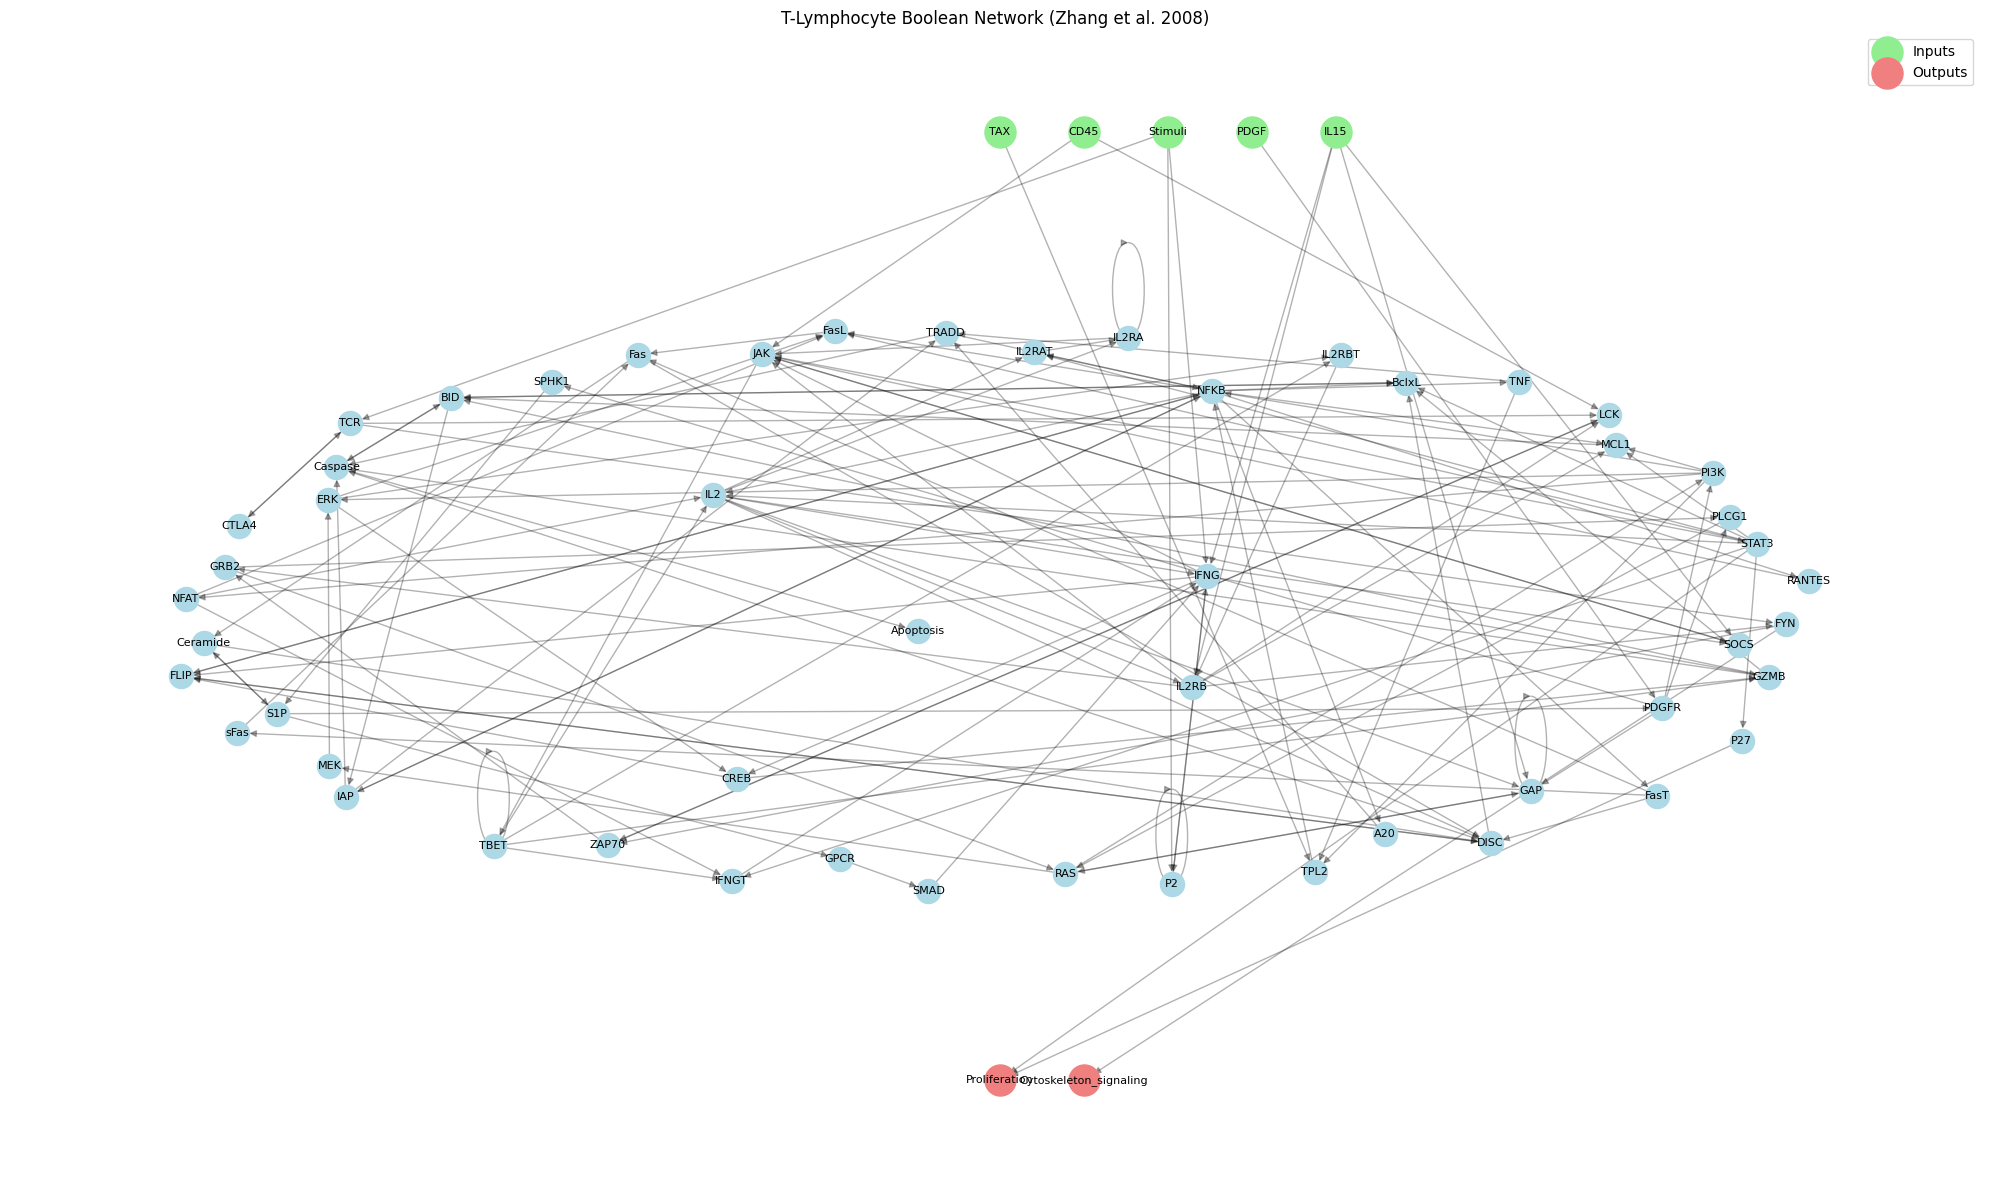

In [33]:
import networkx as nx
import matplotlib.pyplot as plt

# Extract the update method
def extract_network_structure(network_class):
    """Extract network edges from BooleanNetwork.update method"""
    import inspect
    import textwrap
    import ast
    
    # Get the update method source code
    update_method = network_class.update
    source = inspect.getsource(update_method)
    source = textwrap.dedent(source)
    lines = source.split("\n")
    
    edges = []
    
    for line in lines:
        line = line.strip()
        if not line or line.startswith("#"):
            continue
            
        analysis = analyze_line(line)
        if analysis:
            line_text, target_key, source_keys = analysis
            # Create edges: source -> target
            for source_key in source_keys:
                #if source_key != target_key:  # Avoid self-loops for now
                edges.append((source_key, target_key))
    
    return edges

# Build the network graph
edges = extract_network_structure(BooleanNetwork)
G = nx.DiGraph()
G.add_edges_from(edges)

# Identify node types
all_nodes = set(G.nodes())

# Input nodes: only outgoing edges (no incoming)
input_nodes = [n for n in all_nodes if G.in_degree(n) == 0]

# Output nodes: only incoming edges (no outgoing), but exclude Apoptosis from outlinks
output_nodes = [n for n in all_nodes if G.out_degree(n) == 0]

# Middle nodes: everything else
middle_nodes = [n for n in all_nodes if n not in input_nodes and n not in output_nodes]

print(f"Input nodes: {input_nodes}")
print(f"Output nodes: {output_nodes}")
print(f"Total nodes: {len(all_nodes)}")
print(f"Total edges: {len(edges)}")

# Create a hierarchical layout
pos = {}

# Position input nodes at the top
for i, node in enumerate(input_nodes):
    pos[node] = (i * 2, 10)

# Position output nodes at the bottom
for i, node in enumerate(output_nodes):
    pos[node] = (i * 2, 0)

# Position middle nodes using a layout algorithm, then adjust y
middle_pos = nx.spring_layout(G.subgraph(middle_nodes), k=2, iterations=50)
for node, (x, y) in middle_pos.items():
    pos[node] = (x * 20, 5 + y * 3)  # Scale and center vertically

# Visualize
plt.figure(figsize=(20, 12))

# Draw nodes by type
nx.draw_networkx_nodes(G, pos, nodelist=input_nodes, 
                       node_color='lightgreen', node_size=500, label='Inputs')
nx.draw_networkx_nodes(G, pos, nodelist=output_nodes, 
                       node_color='lightcoral', node_size=500, label='Outputs')
nx.draw_networkx_nodes(G, pos, nodelist=middle_nodes, 
                       node_color='lightblue', node_size=300)

# Draw edges (excluding those from Apoptosis as per task)
edges_to_draw = [(u, v) for u, v in G.edges() if u != 'Apoptosis']
nx.draw_networkx_edges(G, pos, edgelist=edges_to_draw, 
                       alpha=0.3, arrows=True, arrowsize=10)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=8)

plt.legend()
plt.title("T-Lymphocyte Boolean Network (Zhang et al. 2008)")
plt.axis('off')
plt.tight_layout()
plt.show()

3. Run parallel update of the network, and identify attractors and fixed points, for a few input settings (fixed combinations of input node states)


In [34]:
import copy

def run_scenario(input_states, max_steps=100):
    """
    Run network with specific input configuration
    
    Args:
        input_states: dict like {"Stimuli": True, "IL2": False}
        max_steps: maximum steps to run
    """
    # Initialize network
    network = BooleanNetwork()
    
    # Set input states (keep them fixed throughout)
    for node, value in input_states.items():
        network.state[node] = value
    
    # Track history
    history = [copy.deepcopy(network.state)]
    
    for step in range(max_steps):
        prev_state = copy.deepcopy(network.state)
        
        # Run one parallel update step
        network.update()
        
        # Re-apply input states (keep them constant)
        for node, value in input_states.items():
            network.state[node] = value
        
        history.append(copy.deepcopy(network.state))
        
        # Check for fixed point
        if network.state == prev_state:
            print(f"  Fixed point at step {step}")
            return network, history, "fixed_point", step
        
        # Check for cycle
        for i, past_state in enumerate(history[:-1]):
            if network.state == past_state:
                cycle_length = len(history) - 1 - i
                print(f"  Cycle detected! Length: {cycle_length}")
                return network, history, "cycle", cycle_length
    
    print(f"  No convergence after {max_steps} steps")
    return network, history, "no_convergence", max_steps
# Input nodes: ['PDGF', 'IL15', 'CD45', 'TAX', 'Stimuli']
# Test different scenarios
scenarios = {
    "Normal activation": {"Stimuli": True},
    "With IL2": {"Stimuli": True, "IL2": True},
    "With IL15": {"Stimuli": True, "IL15": True},
    "Viral (TAX)": {"Stimuli": True, "TAX": True},
    "With PDGF": {"Stimuli": True, "PDGF": True},
    "With CD45": {"Stimuli": True, "CD45": True},
    "No input": {},
}

results = {}
for name, inputs in scenarios.items():
    print(f"\n{'='*60}")
    print(f"SCENARIO: {name}")
    print(f"Inputs: {inputs}")
    print('='*60)
    
    network, history, result_type, info = run_scenario(inputs, max_steps=100)
    results[name] = (network, history, result_type, info)
    
    print(f"  Final state:")
    print(f"    Proliferation: {network.state['Proliferation']}")
    print(f"    Apoptosis: {network.state['Apoptosis']}")
    print(f"    IFNG: {network.state['IFNG']}")
    print(f"    IL2: {network.state['IL2']}")


SCENARIO: Normal activation
Inputs: {'Stimuli': True}
  Cycle detected! Length: 4
  Final state:
    Proliferation: False
    Apoptosis: False
    IFNG: False
    IL2: False

SCENARIO: With IL2
Inputs: {'Stimuli': True, 'IL2': True}
  Cycle detected! Length: 4
  Final state:
    Proliferation: False
    Apoptosis: False
    IFNG: False
    IL2: True

SCENARIO: With IL15
Inputs: {'Stimuli': True, 'IL15': True}
  Cycle detected! Length: 4
  Final state:
    Proliferation: False
    Apoptosis: False
    IFNG: False
    IL2: False

SCENARIO: Viral (TAX)
Inputs: {'Stimuli': True, 'TAX': True}
  Fixed point at step 8
  Final state:
    Proliferation: False
    Apoptosis: True
    IFNG: False
    IL2: False

SCENARIO: With PDGF
Inputs: {'Stimuli': True, 'PDGF': True}
  Fixed point at step 9
  Final state:
    Proliferation: False
    Apoptosis: True
    IFNG: False
    IL2: False

SCENARIO: With CD45
Inputs: {'Stimuli': True, 'CD45': True}
  Fixed point at step 12
  Final state:
    Prolifer

4. Run random stochastic update of the network for a few input settings. Establish time-averaged node activity and color-code it on the graph.


In [35]:
import random
from collections import Counter
import numpy as np
import copy

def stochastic_update_step(state):
    """
    Pick one random node and update it.
    Keeps input nodes unchanged.
    """
    # Nodes that can be updated (exclude external inputs)
    updatable_nodes = [
        "CTLA4", "TCR", "PDGFR", "FYN", "Cytoskeleton_signaling", 
        "LCK", "ZAP70", "GRB2", "PLCG1", "RAS", "GAP", "MEK", "ERK",
        "PI3K", "NFKB", "NFAT", "RANTES", "IL2", "IL2RBT", "IL2RB",
        "IL2RAT", "IL2RA", "JAK", "SOCS", "STAT3", "P27", "Proliferation",
        "TBET", "CREB", "IFNGT", "IFNG", "P2", "GZMB", "TPL2", "TNF",
        "TRADD", "FasL", "FasT", "Fas", "sFas", "Ceramide", "DISC",
        "Caspase", "Apoptosis", "FLIP", "A20", "BID", "IAP", "BclxL",
        "MCL1", "GPCR", "SMAD", "SPHK1", "S1P"
    ]
    
    # Pick one random node
    node = random.choice(updatable_nodes)
    
    # Update rules (from BooleanNetwork.update method)
    s = state
    
    if node == "CTLA4":
        state[node] = s["TCR"] and not s["Apoptosis"]
    elif node == "TCR":
        state[node] = s["Stimuli"] and not (s["CTLA4"] or s["Apoptosis"])
    elif node == "PDGFR":
        state[node] = (s["S1P"] or s["PDGF"]) and not s["Apoptosis"]
    elif node == "FYN":
        state[node] = (s["TCR"] or s["IL2RB"]) and not s["Apoptosis"]
    elif node == "Cytoskeleton_signaling":
        state[node] = s["FYN"] and not s["Apoptosis"]
    elif node == "LCK":
        state[node] = (s["CD45"] or ((s["TCR"] or s["IL2RB"]) and not s["ZAP70"])) and not s["Apoptosis"]
    elif node == "ZAP70":
        state[node] = s["LCK"] and not (s["FYN"] or s["Apoptosis"])
    elif node == "GRB2":
        state[node] = (s["IL2RB"] or s["ZAP70"]) and not s["Apoptosis"]
    elif node == "PLCG1":
        state[node] = (s["GRB2"] or s["PDGFR"]) and not s["Apoptosis"]
    elif node == "RAS":
        state[node] = (s["GRB2"] or s["PLCG1"]) and not (s["GAP"] or s["Apoptosis"])
    elif node == "GAP":
        state[node] = (s["RAS"] or (s["PDGFR"] and s["GAP"])) and not (s["IL15"] or s["IL2"] or s["Apoptosis"])
    elif node == "MEK":
        state[node] = s["RAS"] and not s["Apoptosis"]
    elif node == "ERK":
        state[node] = (s["MEK"] and s["PI3K"]) and not s["Apoptosis"]
    elif node == "PI3K":
        state[node] = (s["PDGFR"] or s["RAS"]) and not s["Apoptosis"]
    elif node == "NFKB":
        state[node] = ((s["TPL2"] or s["PI3K"]) or (s["FLIP"] and s["TRADD"] and s["IAP"])) and not s["Apoptosis"]
    elif node == "NFAT":
        state[node] = s["PI3K"] and not s["Apoptosis"]
    elif node == "RANTES":
        state[node] = s["NFKB"] and not s["Apoptosis"]
    elif node == "IL2":
        state[node] = (s["NFKB"] or s["STAT3"] or s["NFAT"]) and not (s["TBET"] or s["Apoptosis"])
    elif node == "IL2RBT":
        state[node] = (s["ERK"] and s["TBET"]) and not s["Apoptosis"]
    elif node == "IL2RB":
        state[node] = (s["IL2RBT"] and (s["IL2"] or s["IL15"])) and not s["Apoptosis"]
    elif node == "IL2RAT":
        state[node] = (s["IL2"] and (s["STAT3"] or s["NFKB"])) and not s["Apoptosis"]
    elif node == "IL2RA":
        state[node] = (s["IL2"] and s["IL2RAT"]) and not (s["IL2RA"] or s["Apoptosis"])
    elif node == "JAK":
        state[node] = (s["IL2RA"] or s["IL2RB"] or s["RANTES"] or s["IFNG"]) and not (s["SOCS"] or s["CD45"] or s["Apoptosis"])
    elif node == "SOCS":
        state[node] = s["JAK"] and not (s["Apoptosis"] or s["IL2"] or s["IL15"])
    elif node == "STAT3":
        state[node] = s["JAK"] and not s["Apoptosis"]
    elif node == "P27":
        state[node] = s["STAT3"] and not s["Apoptosis"]
    elif node == "Proliferation":
        state[node] = s["STAT3"] and not (s["P27"] or s["Apoptosis"])
    elif node == "TBET":
        state[node] = (s["JAK"] or s["TBET"]) and not s["Apoptosis"]
    elif node == "CREB":
        state[node] = (s["ERK"] and s["IFNG"]) and not s["Apoptosis"]
    elif node == "IFNGT":
        state[node] = (s["TBET"] or s["STAT3"] or s["NFAT"]) and not s["Apoptosis"]
    elif node == "IFNG":
        state[node] = ((s["IL2"] or s["IL15"] or s["Stimuli"]) and s["IFNGT"]) and not (s["Apoptosis"] or s["SMAD"] or s["P2"])
    elif node == "P2":
        state[node] = (s["IFNG"] or s["P2"]) and not (s["Stimuli"] or s["Apoptosis"])
    elif node == "GZMB":
        state[node] = ((s["CREB"] and s["IFNG"]) or s["TBET"]) and not s["Apoptosis"]
    elif node == "TPL2":
        state[node] = (s["TAX"] or (s["PI3K"] and s["TNF"])) and not s["Apoptosis"]
    elif node == "TNF":
        state[node] = s["NFKB"] and not s["Apoptosis"]
    elif node == "TRADD":
        state[node] = s["TNF"] and not (s["IAP"] or s["A20"] or s["Apoptosis"])
    elif node == "FasL":
        state[node] = (s["STAT3"] or s["NFKB"] or s["NFAT"] or s["ERK"]) and not s["Apoptosis"]
    elif node == "FasT":
        state[node] = s["NFKB"] and not s["Apoptosis"]
    elif node == "Fas":
        state[node] = (s["FasT"] and s["FasL"]) and not (s["sFas"] or s["Apoptosis"])
    elif node == "sFas":
        state[node] = s["FasT"] and not s["Apoptosis"]
    elif node == "Ceramide":
        state[node] = s["Fas"] and not (s["S1P"] or s["Apoptosis"])
    elif node == "DISC":
        state[node] = (s["FasT"] and ((s["Fas"] and s["IL2"]) or s["Ceramide"] or (s["Fas"] and not s["FLIP"]))) and not s["Apoptosis"]
    elif node == "Caspase":
        state[node] = (((s["TRADD"] or s["GZMB"]) and s["BID"] and not s["IAP"]) or s["DISC"]) and not s["Apoptosis"]
    elif node == "Apoptosis":
        state[node] = s["Caspase"] or s["Apoptosis"]
    elif node == "FLIP":
        state[node] = (s["NFKB"] or (s["CREB"] and s["IFNG"])) and not (s["DISC"] or s["Apoptosis"])
    elif node == "A20":
        state[node] = s["NFKB"] and not s["Apoptosis"]
    elif node == "BID":
        state[node] = (s["Caspase"] or s["GZMB"]) and not (s["BclxL"] or s["MCL1"] or s["Apoptosis"])
    elif node == "IAP":
        state[node] = s["NFKB"] and not (s["BID"] or s["Apoptosis"])
    elif node == "BclxL":
        state[node] = (s["NFKB"] or s["STAT3"]) and not (s["BID"] or s["GZMB"] or s["DISC"] or s["Apoptosis"])
    elif node == "MCL1":
        state[node] = (s["IL2RB"] and s["STAT3"] and s["NFKB"] and s["PI3K"]) and not s["Apoptosis"]
    elif node == "GPCR":
        state[node] = s["S1P"] and not s["Apoptosis"]
    elif node == "SMAD":
        state[node] = s["GPCR"] and not s["Apoptosis"]
    elif node == "SPHK1":
        state[node] = s["PDGFR"] and not s["Apoptosis"]
    elif node == "S1P":
        state[node] = s["SPHK1"] and not (s["Ceramide"] or s["Apoptosis"])
    
    return state


def run_stochastic(input_states, num_steps=10000, burn_in=1000):
    """
    Run stochastic updates and calculate time-averaged activity
    Stops 100 steps after apoptosis is activated.
    
    Args:
        input_states: dict of fixed input values
        num_steps: maximum number of random update steps
        burn_in: number of initial steps to discard (let system equilibrate)
    """
    
    # Initialize
    network = BooleanNetwork()
    
    # Set inputs (keep these fixed throughout)
    for node, value in input_states.items():
        network.state[node] = value
    
    # Burn-in period (let system equilibrate)
    for _ in range(burn_in):
        network.state = stochastic_update_step(network.state)
        # Keep inputs fixed
        for node, value in input_states.items():
            network.state[node] = value
    
    # Track activity (how often each node is True)
    activity_counter = Counter()
    
    # Track apoptosis activation
    apoptosis_activated_step = None
    steps_after_apoptosis = 0
    actual_steps = 0
    
    # Run stochastic updates and count
    for step in range(num_steps):
        # Update one random node
        network.state = stochastic_update_step(network.state)
        
        # Keep inputs fixed
        for node, value in input_states.items():
            network.state[node] = value
        
        # Check if apoptosis just activated
        if network.state["Apoptosis"] and apoptosis_activated_step is None:
            apoptosis_activated_step = step
        
        # Count steps after apoptosis
        if apoptosis_activated_step is not None:
            steps_after_apoptosis = step - apoptosis_activated_step
            # Stop 100 steps after apoptosis activation
            if steps_after_apoptosis >= 100:
                actual_steps = step + 1
                break
        
        # Count which nodes are active
        for node, value in network.state.items():
            if value:
                activity_counter[node] += 1
        
        actual_steps = step + 1
    
    # Calculate time-averaged activity (fraction of time each node is True)
    time_avg_activity = {
        node: activity_counter.get(node, 0) / actual_steps 
        for node in network.state.keys()
    }
    
    return time_avg_activity

def run_multiple_stochastic_trials(input_states, num_trials=10, num_steps=10000, burn_in=1000):
    """
    Run multiple stochastic trials and compute average activity across trials
    
    Args:
        input_states: dict of fixed input values
        num_trials: number of independent trials to run
        num_steps: number of update steps per trial
        burn_in: number of initial steps to discard per trial
    
    Returns:
        dict with mean and std of activity for each node
    """
    all_trials = []
    
    for trial in range(num_trials):
        activity = run_stochastic(input_states, num_steps=num_steps, burn_in=burn_in)
        all_trials.append(activity)
    
    # Get all node names
    all_nodes = all_trials[0].keys()
    
    # Calculate mean and std across trials
    mean_activity = {}
    std_activity = {}
    
    for node in all_nodes:
        activities = [trial[node] for trial in all_trials]
        mean_activity[node] = np.mean(activities)
        std_activity[node] = np.std(activities)
    
    return mean_activity, std_activity

# Run stochastic updates for all scenarios with multiple trials
print("="*80)
print("TASK 4: STOCHASTIC UPDATES - TIME-AVERAGED ACTIVITY (10 TRIALS)")
print("="*80)

stochastic_results = {}

for name, inputs in scenarios.items():
    print(f"\n{'='*80}")
    print(f"SCENARIO: {name}")
    print(f"Inputs: {inputs}")
    print('='*80)
    
    # Run 10 stochastic trials
    mean_activity, std_activity = run_multiple_stochastic_trials(
        inputs, 
        num_trials=10, 
        num_steps=10000, 
        burn_in=1000
    )
    
    stochastic_results[name] = {
        'mean': mean_activity,
        'std': std_activity
    }
    
    # Show most active nodes
    print("\nTop active nodes (mean activity > 0.01):")
    sorted_activity = sorted(mean_activity.items(), key=lambda x: x[1], reverse=True)
    for node, mean_val in sorted_activity:
        if mean_val > 0.01:  # Show nodes active >1% of time
            std_val = std_activity[node]
            print(f"  {node:25s}: {mean_val:.3f} ± {std_val:.3f}")
    
    # Show key outcome nodes
    print("\nKey outcomes (mean ± std):")
    print(f"  Proliferation: {mean_activity['Proliferation']:.3f} ± {std_activity['Proliferation']:.3f}")
    print(f"  Apoptosis:     {mean_activity['Apoptosis']:.3f} ± {std_activity['Apoptosis']:.3f}")
    print(f"  IFNG:          {mean_activity['IFNG']:.3f} ± {std_activity['IFNG']:.3f}")
    print(f"  IL2:           {mean_activity['IL2']:.3f} ± {std_activity['IL2']:.3f}")

# Summary comparison across scenarios
print(f"\n{'='*80}")
print("SUMMARY: KEY OUTCOMES ACROSS ALL SCENARIOS")
print('='*80)
print(f"{'Scenario':<25s} {'Proliferation':>15s} {'Apoptosis':>15s} {'IFNG':>15s} {'IL2':>15s}")
print("-"*80)

for name in scenarios.keys():
    mean = stochastic_results[name]['mean']
    std = stochastic_results[name]['std']
    
    print(f"{name:<25s} "
          f"{mean['Proliferation']:>6.3f}±{std['Proliferation']:<6.3f} "
          f"{mean['Apoptosis']:>6.3f}±{std['Apoptosis']:<6.3f} "
          f"{mean['IFNG']:>6.3f}±{std['IFNG']:<6.3f} "
          f"{mean['IL2']:>6.3f}±{std['IL2']:<6.3f}")

TASK 4: STOCHASTIC UPDATES - TIME-AVERAGED ACTIVITY (10 TRIALS)

SCENARIO: Normal activation
Inputs: {'Stimuli': True}

Top active nodes (mean activity > 0.01):
  Stimuli                  : 0.998 ± 0.003
  CTLA4                    : 0.409 ± 0.224
  TCR                      : 0.378 ± 0.192
  FasL                     : 0.353 ± 0.331
  IFNGT                    : 0.334 ± 0.270
  FYN                      : 0.322 ± 0.186
  Cytoskeleton_signaling   : 0.310 ± 0.192
  TBET                     : 0.293 ± 0.248
  LCK                      : 0.257 ± 0.153
  IAP                      : 0.255 ± 0.298
  Apoptosis                : 0.227 ± 0.307
  IFNG                     : 0.216 ± 0.207
  GZMB                     : 0.213 ± 0.162
  JAK                      : 0.190 ± 0.180
  STAT3                    : 0.188 ± 0.179
  BID                      : 0.174 ± 0.157
  RANTES                   : 0.171 ± 0.190
  Caspase                  : 0.170 ± 0.298
  MEK                      : 0.164 ± 0.176
  FLIP                

Generating activity visualization for each scenario...

Visualizing: Normal activation


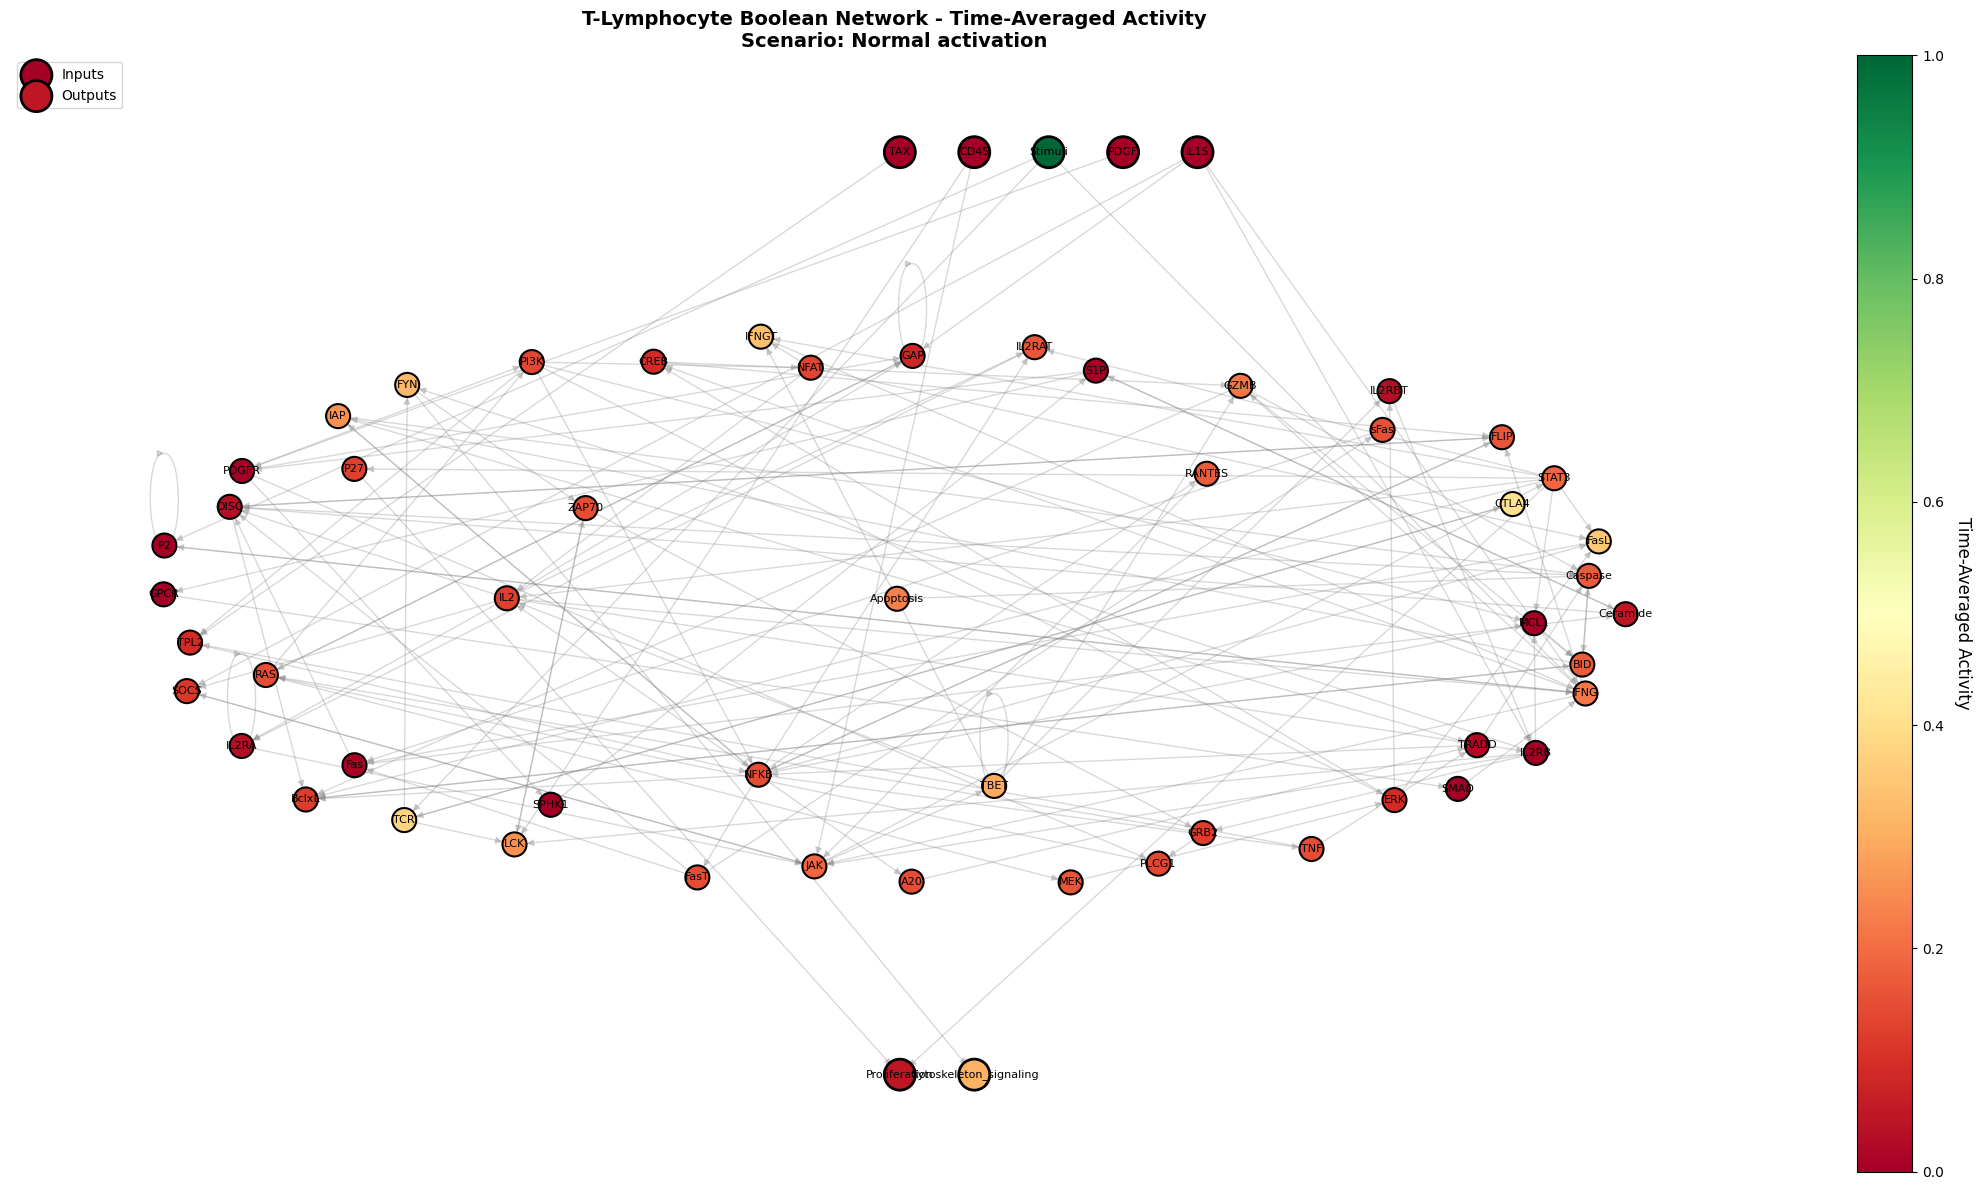


Visualizing: With IL2


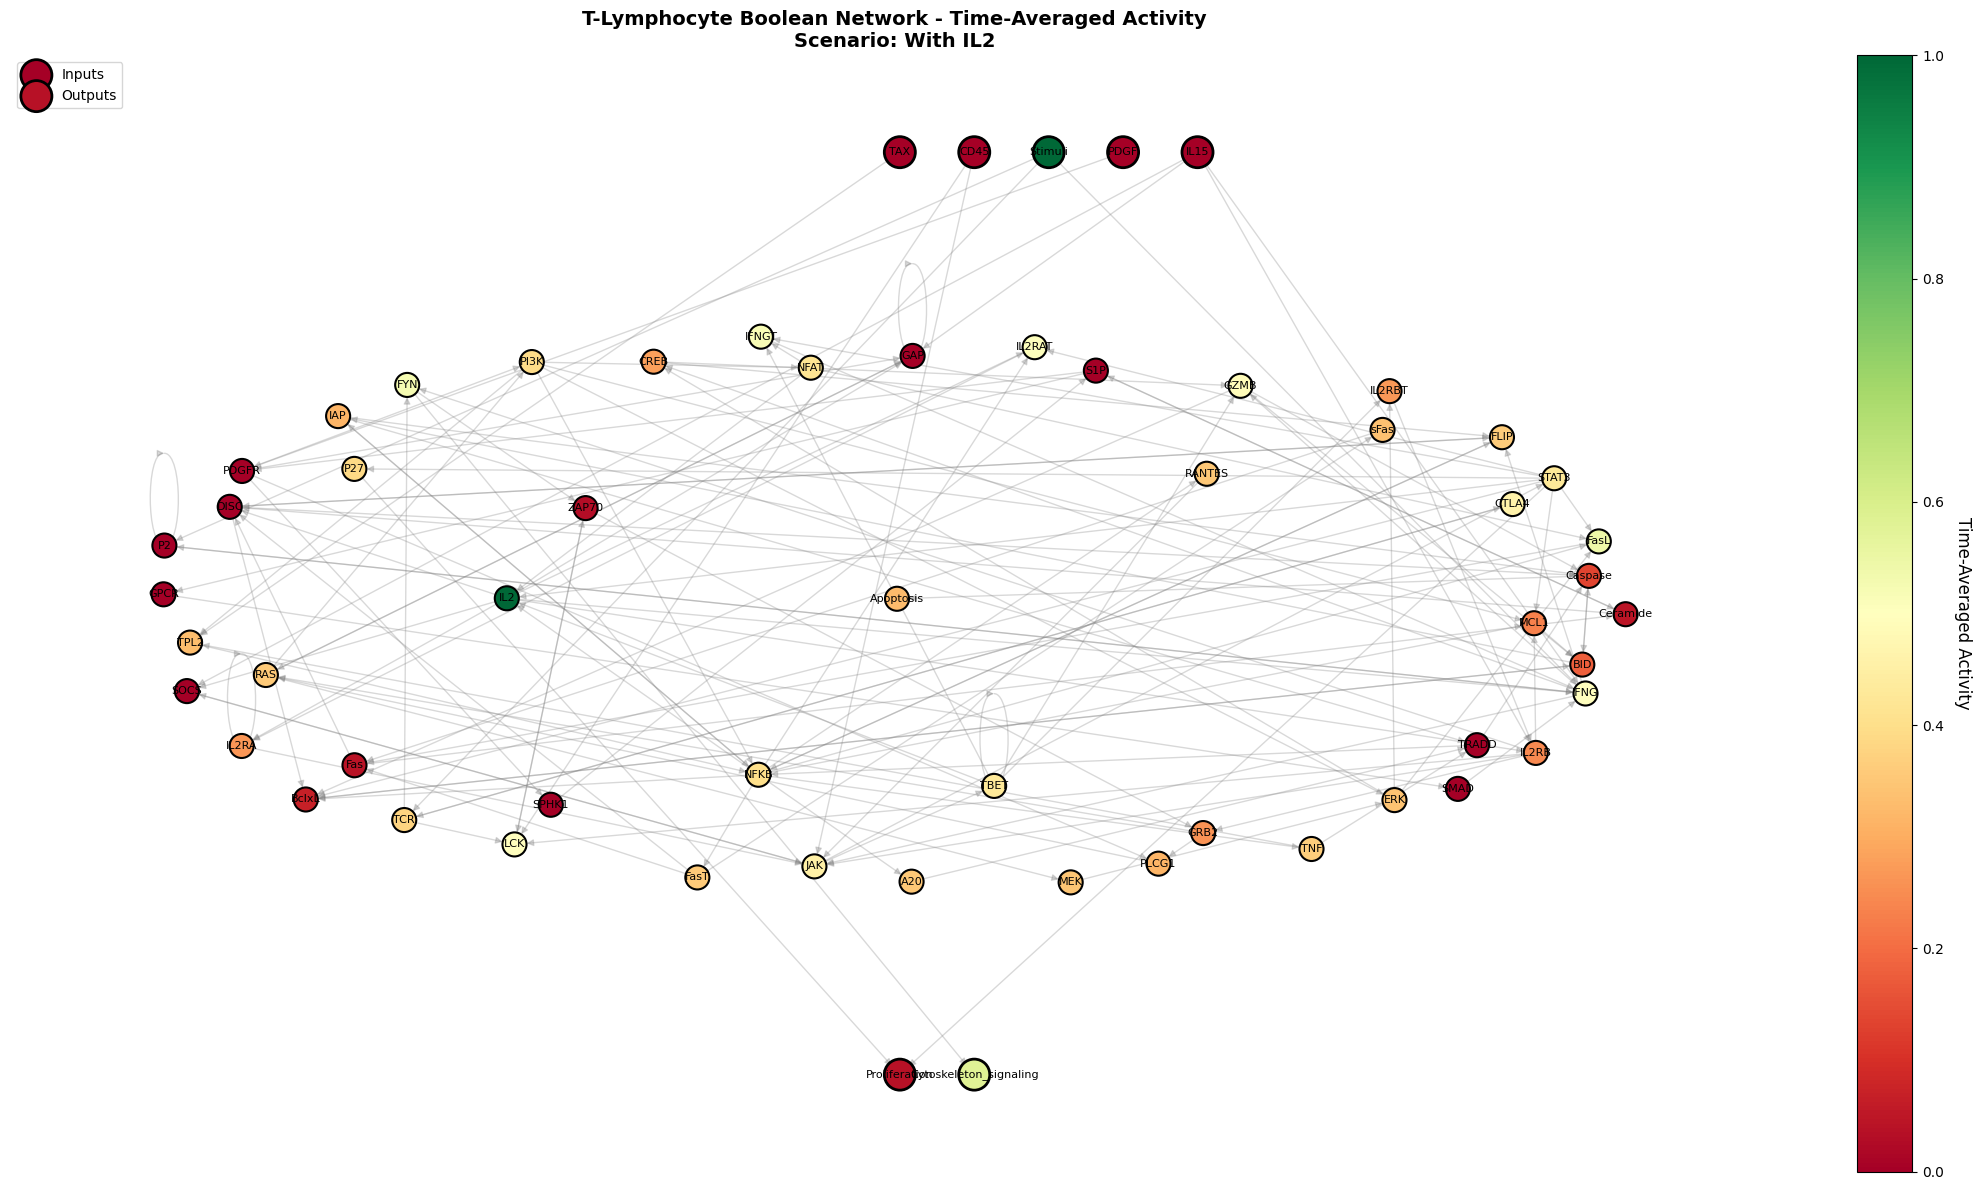


Visualizing: With IL15


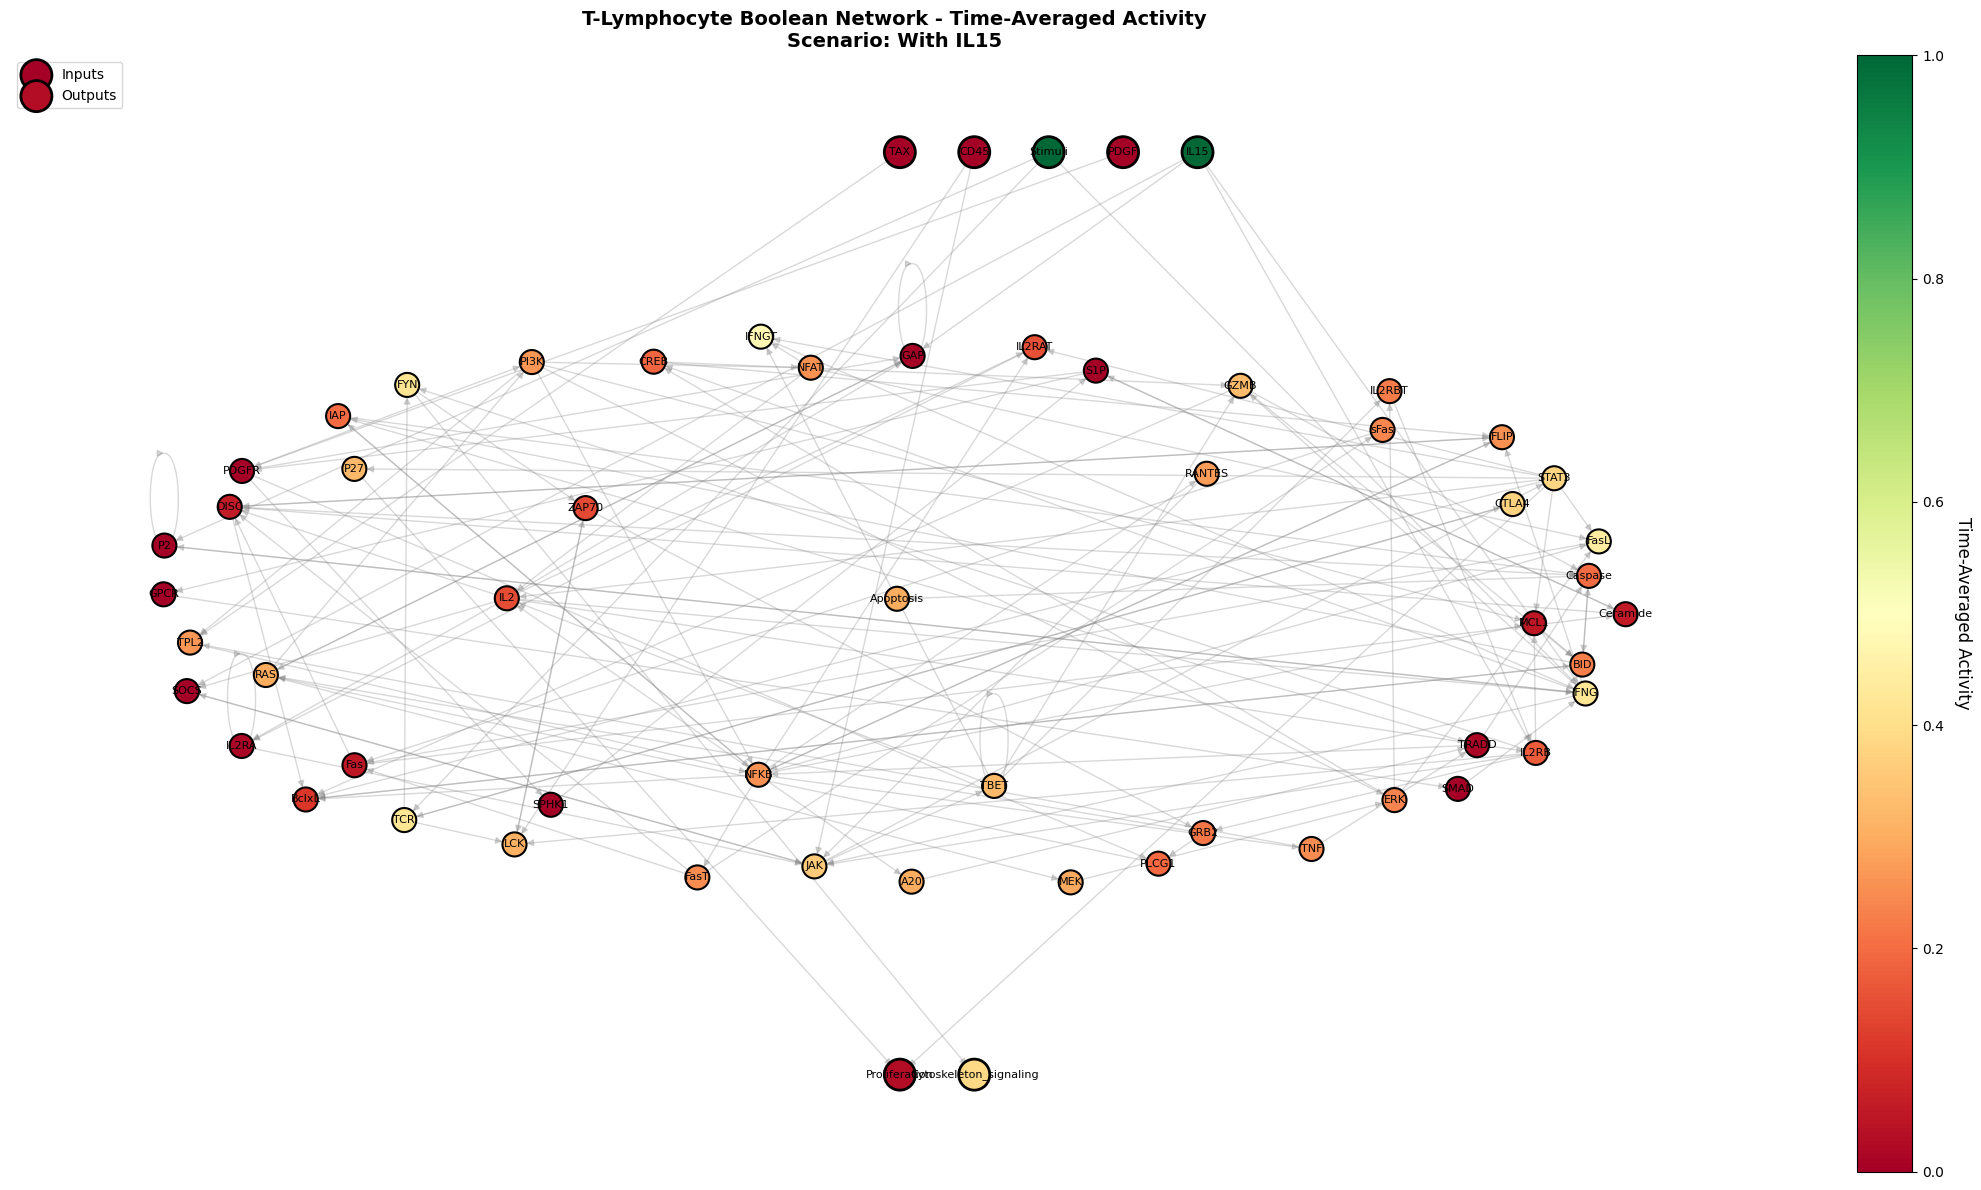


Visualizing: Viral (TAX)


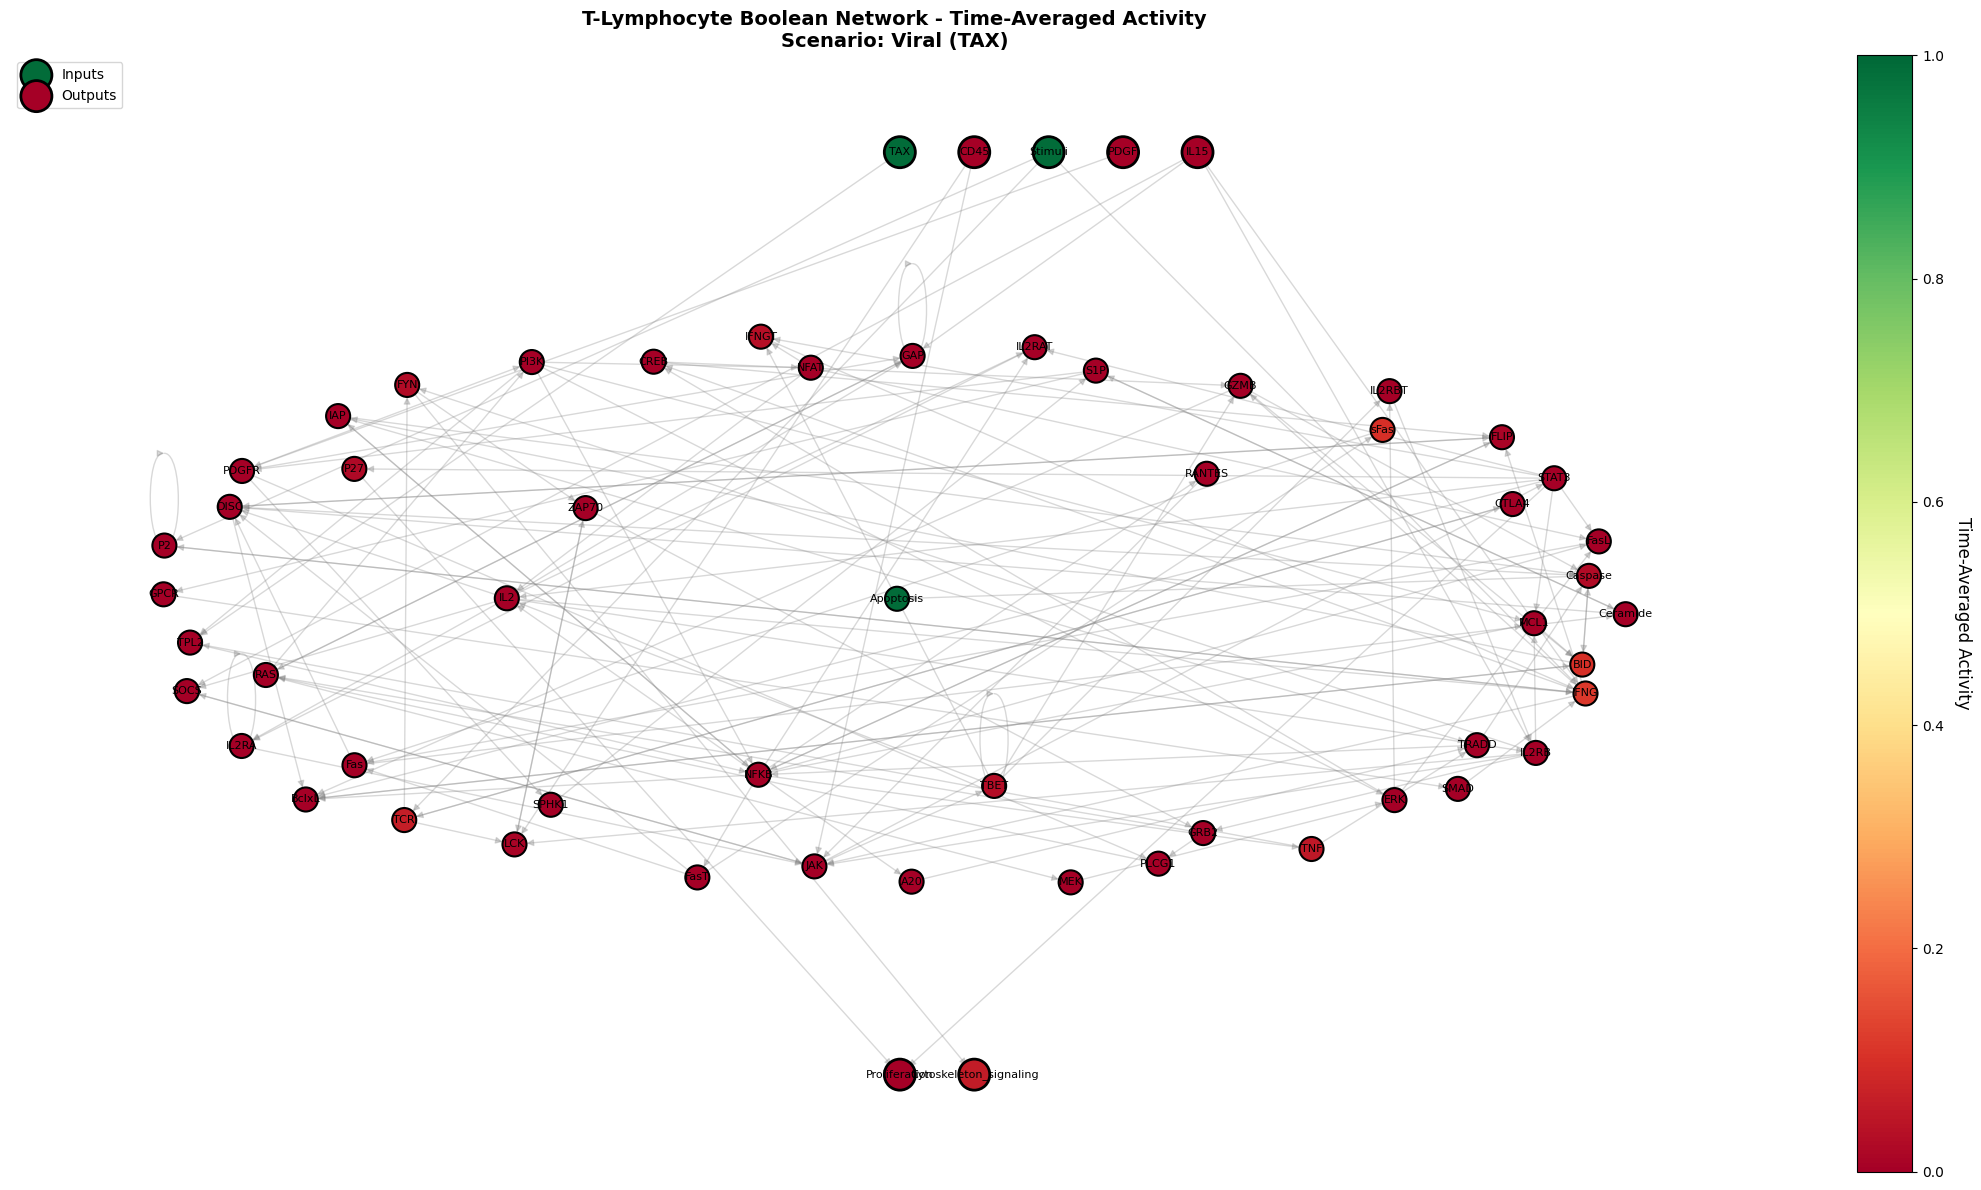


Visualizing: With PDGF


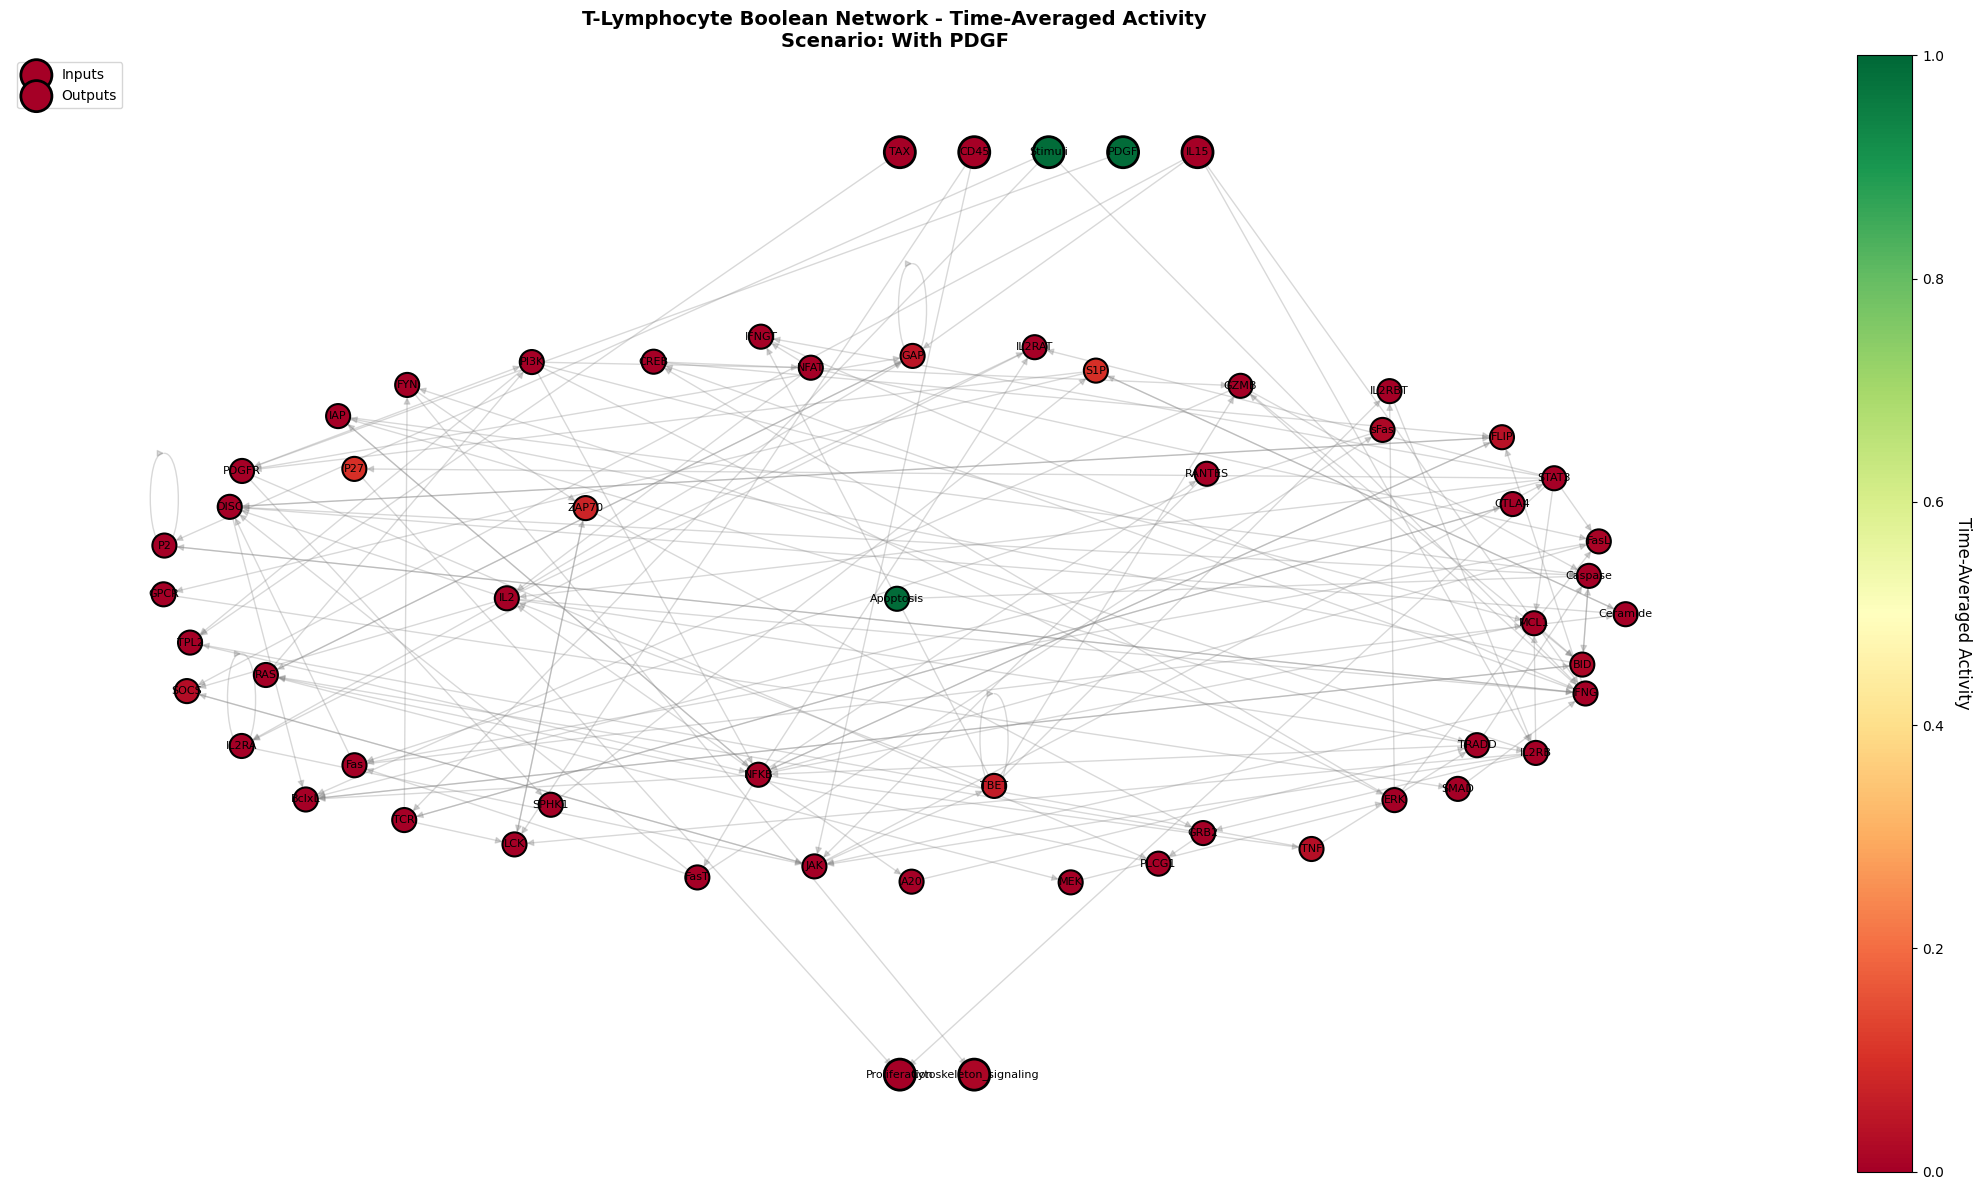


Visualizing: With CD45


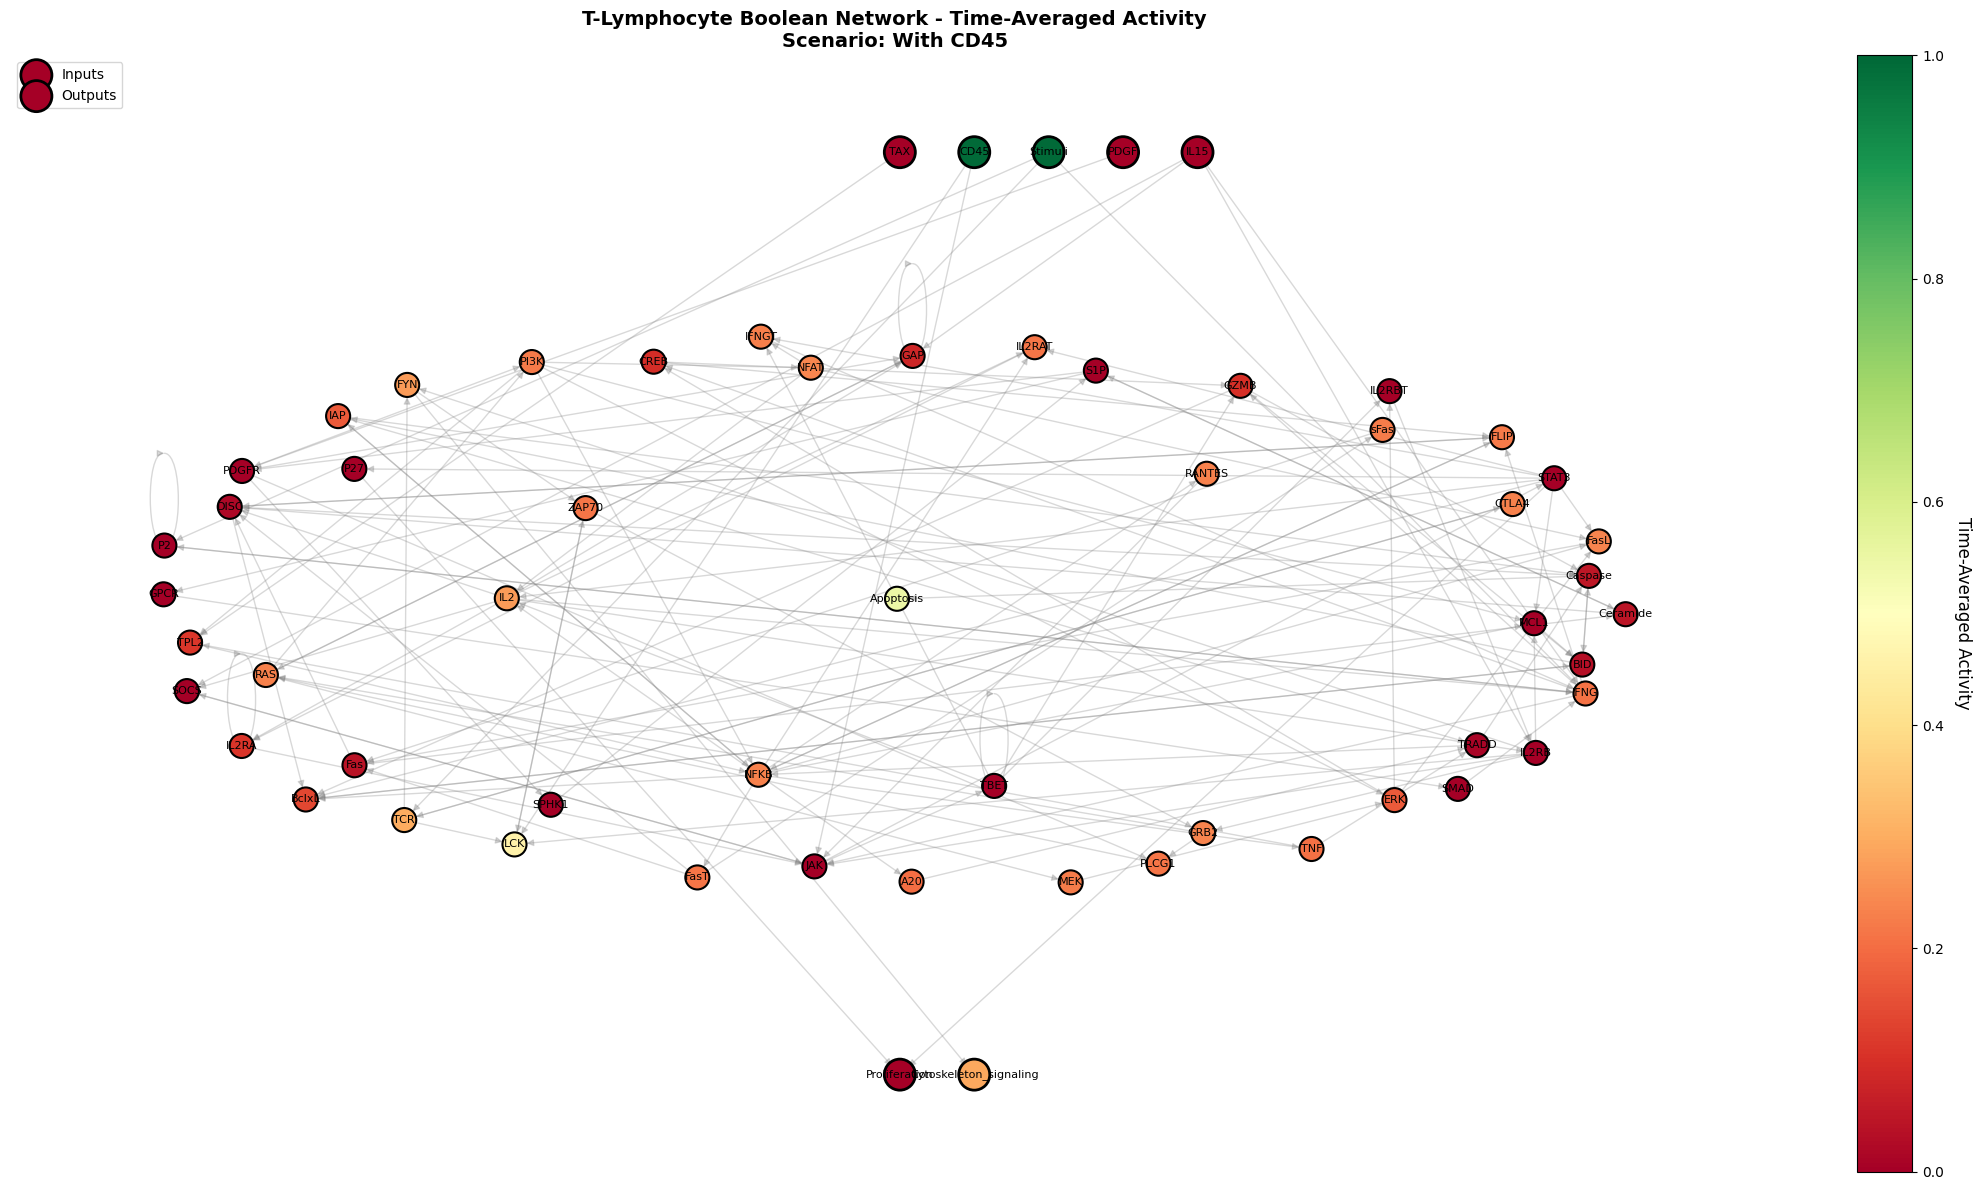


Visualizing: No input


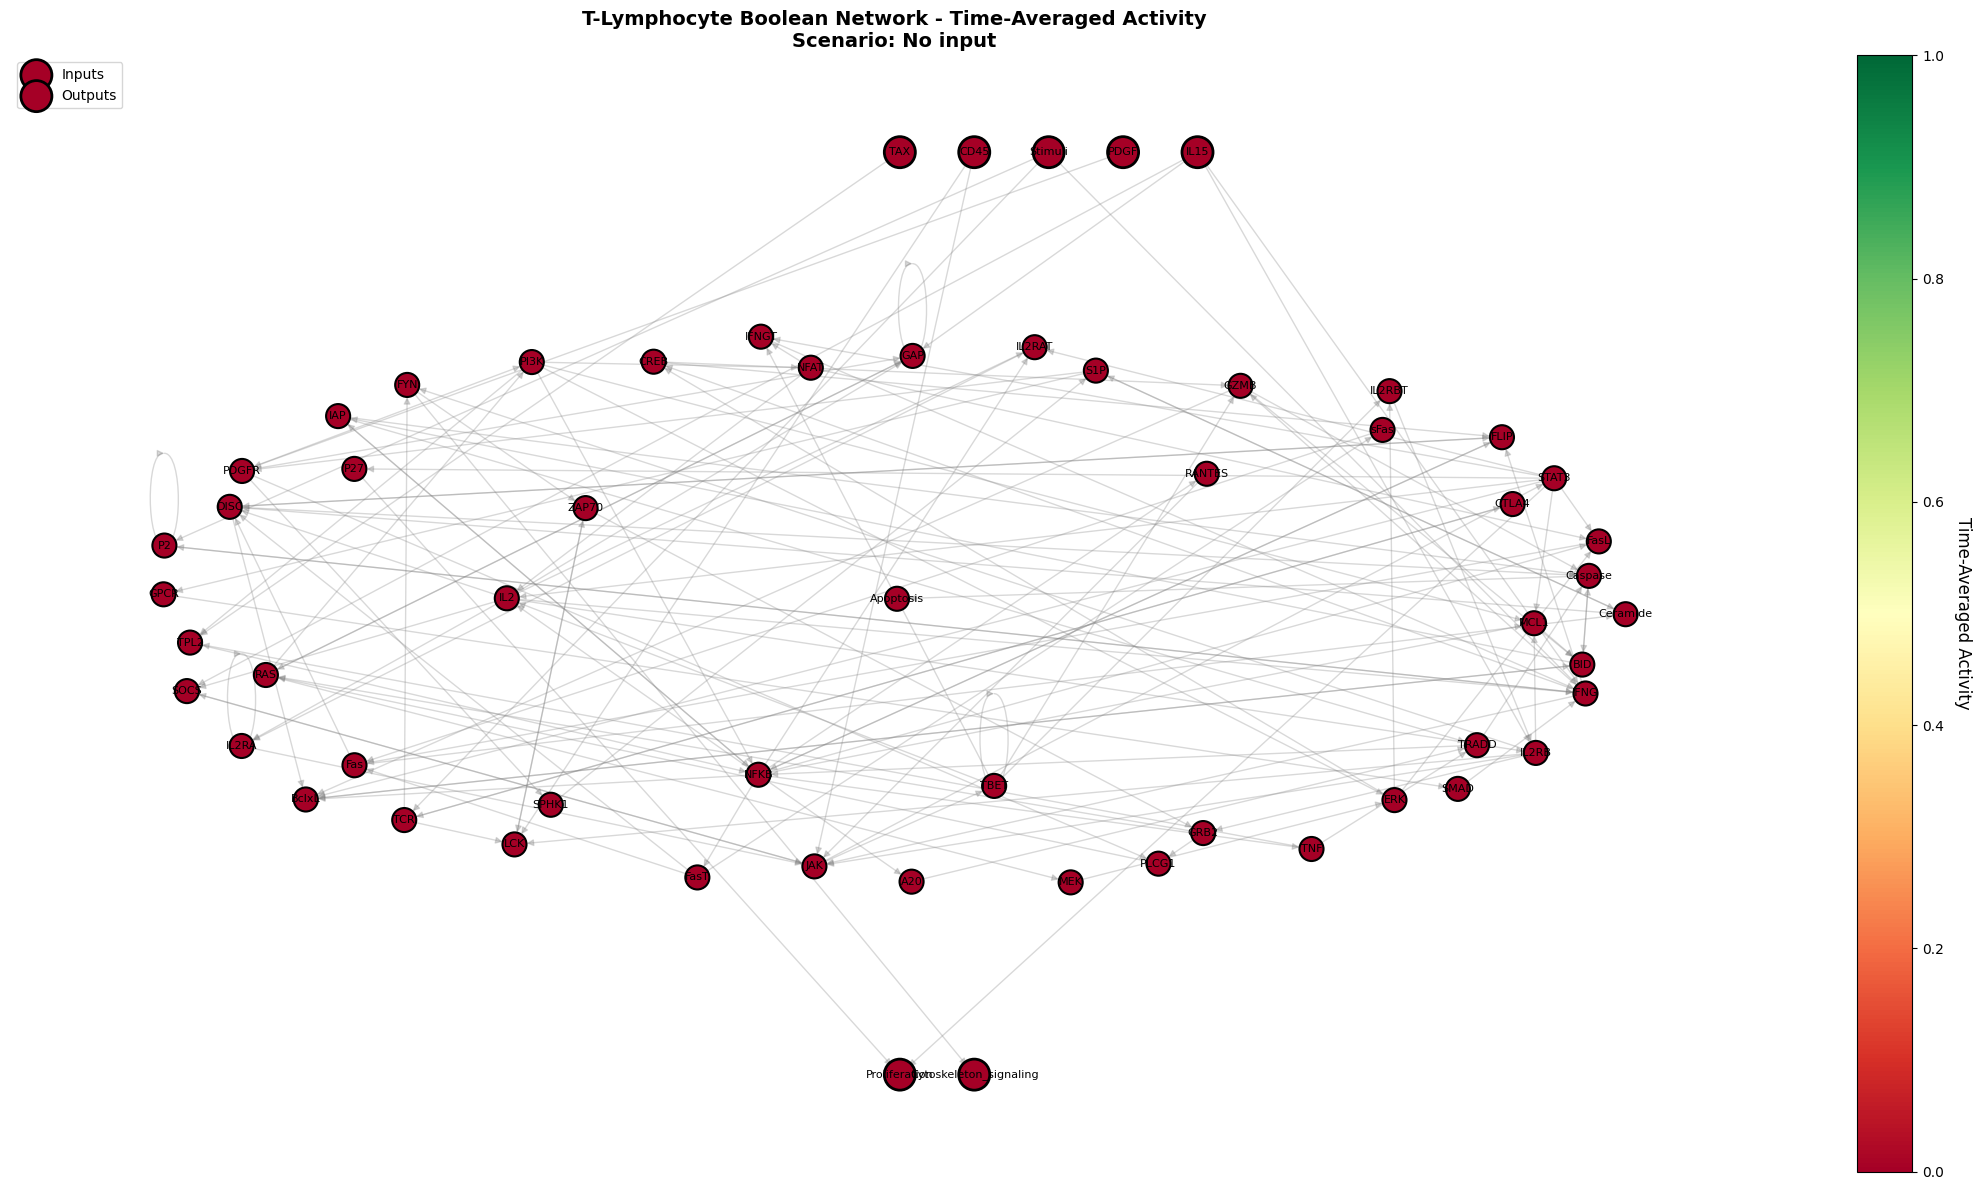

In [36]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def visualize_activity_on_graph(G, activity_dict, scenario_name, 
                                input_nodes, output_nodes, middle_nodes,
                                cmap='RdYlGn', figsize=(20, 12)):
    """
    Visualize network graph with nodes colored by time-averaged activity
    Uses the same hierarchical layout as Cell 3
    
    Args:
        G: NetworkX DiGraph
        activity_dict: dict mapping node names to activity values (0-1)
        scenario_name: name of the scenario for the title
        input_nodes: list of input node names
        output_nodes: list of output node names
        middle_nodes: list of middle node names
        cmap: matplotlib colormap
        figsize: figure size
    """
    plt.figure(figsize=figsize)
    
    # Create hierarchical layout (same as Cell 3)
    pos = {}
    
    # Position input nodes at the top
    for i, node in enumerate(input_nodes):
        pos[node] = (i * 2, 10)
    
    # Position output nodes at the bottom
    for i, node in enumerate(output_nodes):
        pos[node] = (i * 2, 0)
    
    # Position middle nodes using spring layout
    middle_pos = nx.spring_layout(G.subgraph(middle_nodes), k=2, iterations=50, seed=42)
    for node, (x, y) in middle_pos.items():
        pos[node] = (x * 20, 5 + y * 3)  # Scale and center vertically
    
    # Get node colors based on activity
    node_colors_input = [activity_dict.get(node, 0) for node in input_nodes]
    node_colors_output = [activity_dict.get(node, 0) for node in output_nodes]
    node_colors_middle = [activity_dict.get(node, 0) for node in middle_nodes]
    
    # Draw edges (excluding those from Apoptosis as per task)
    edges_to_draw = [(u, v) for u, v in G.edges() if u != 'Apoptosis']
    nx.draw_networkx_edges(G, pos, edgelist=edges_to_draw, 
                           alpha=0.3, arrows=True, arrowsize=10,
                           edge_color='gray')
    
    # Draw nodes by type with activity coloring
    nodes_input = nx.draw_networkx_nodes(G, pos, nodelist=input_nodes, 
                                         node_color=node_colors_input,
                                         node_size=500,
                                         cmap=cmap,
                                         vmin=0, vmax=1,
                                         edgecolors='black',
                                         linewidths=2,
                                         label='Inputs')
    
    nodes_output = nx.draw_networkx_nodes(G, pos, nodelist=output_nodes, 
                                          node_color=node_colors_output,
                                          node_size=500,
                                          cmap=cmap,
                                          vmin=0, vmax=1,
                                          edgecolors='black',
                                          linewidths=2,
                                          label='Outputs')
    
    nodes_middle = nx.draw_networkx_nodes(G, pos, nodelist=middle_nodes, 
                                          node_color=node_colors_middle,
                                          node_size=300,
                                          cmap=cmap,
                                          vmin=0, vmax=1,
                                          edgecolors='black',
                                          linewidths=1.5)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.046, pad=0.04)
    cbar.set_label('Time-Averaged Activity', rotation=270, labelpad=20, fontsize=12)
    
    plt.legend(loc='upper left')
    plt.title(f"T-Lymphocyte Boolean Network - Time-Averaged Activity\nScenario: {scenario_name}", 
              fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize activity for each scenario using the same layout
print("Generating activity visualization for each scenario...")

for scenario_name in scenarios.keys():
    print(f"\nVisualizing: {scenario_name}")
    
    # Get the mean activity for this scenario
    mean_activity = stochastic_results[scenario_name]['mean']
    
    # Create the visualization
    visualize_activity_on_graph(G, mean_activity, scenario_name,
                               input_nodes, output_nodes, middle_nodes)

## Task 5: Robustness Analysis - Identify Targets to Interfere with Apoptosis

We will:
1. Test systematic knockout (force OFF) and activation (force ON) of each node
2. Measure impact on apoptosis across multiple scenarios
3. Identify which nodes are most effective at preventing or promoting apoptosis
4. Analyze network structure to find critical chokepoints


In [37]:
import pandas as pd

def analyze_interventions(input_states, target_output="Apoptosis", num_trials=5, num_steps=5000):
    """
    Test effect of knocking out or activating each node on the target output
    
    Args:
        input_states: baseline input configuration
        target_output: which output to measure (default: "Apoptosis")
        num_trials: number of stochastic trials per intervention
        num_steps: steps per trial
    
    Returns:
        DataFrame with intervention results
    """
    # Get baseline activity
    print(f"  Running baseline...")
    baseline_mean, baseline_std = run_multiple_stochastic_trials(
        input_states, num_trials=num_trials, num_steps=num_steps, burn_in=500
    )
    baseline_value = baseline_mean[target_output]
    
    results = []
    
    # Get all nodes except external inputs that should remain fixed
    network = BooleanNetwork()
    all_nodes = list(network.state.keys())
    external_inputs = list(input_states.keys())  # Keep scenario inputs fixed
    testable_nodes = [n for n in all_nodes if n not in external_inputs and n != target_output]
    
    print(f"  Testing {len(testable_nodes)} nodes...")
    
    for i, node in enumerate(testable_nodes):
        if (i + 1) % 10 == 0:
            print(f"    Progress: {i+1}/{len(testable_nodes)} nodes tested")
        
        # Test knockout (fix to False)
        knockout_inputs = input_states.copy()
        knockout_inputs[node] = False
        mean_ko, std_ko = run_multiple_stochastic_trials(
            knockout_inputs, num_trials=num_trials, num_steps=num_steps, burn_in=500
        )
        
        # Test activation (fix to True)
        activate_inputs = input_states.copy()
        activate_inputs[node] = True
        mean_act, std_act = run_multiple_stochastic_trials(
            activate_inputs, num_trials=num_trials, num_steps=num_steps, burn_in=500
        )
        
        results.append({
            'node': node,
            'baseline': baseline_value,
            'baseline_std': baseline_std[target_output],
            'knockout': mean_ko[target_output],
            'knockout_std': std_ko[target_output],
            'activate': mean_act[target_output],
            'activate_std': std_act[target_output],
            'knockout_effect': mean_ko[target_output] - baseline_value,
            'activate_effect': mean_act[target_output] - baseline_value
        })
    
    df = pd.DataFrame(results)
    
    # Add column for maximum absolute effect (sensitivity measure)
    df['max_effect'] = df[['knockout_effect', 'activate_effect']].abs().max(axis=1)
    
    return df

# Run intervention analysis for key scenarios
print("="*80)
print("TASK 5: ROBUSTNESS ANALYSIS - INTERVENTION TESTING")
print("="*80)
print("\nTesting systematic node interventions to identify targets affecting apoptosis...")

intervention_results = {}

# Test scenarios where apoptosis behavior differs
test_scenarios = {
    "Normal activation": {"Stimuli": True},
    "Viral (TAX)": {"Stimuli": True, "TAX": True},
}

for scenario_name, inputs in test_scenarios.items():
    print(f"\n{'='*80}")
    print(f"SCENARIO: {scenario_name}")
    print(f"Inputs: {inputs}")
    print('='*80)
    
    results_df = analyze_interventions(inputs, target_output="Apoptosis", num_trials=5, num_steps=5000)
    intervention_results[scenario_name] = results_df
    
    print(f"\n  Baseline apoptosis: {results_df.iloc[0]['baseline']:.3f} ± {results_df.iloc[0]['baseline_std']:.3f}")
    print(f"  Total nodes tested: {len(results_df)}")
    
    # Show top results
    print(f"\n  TOP 10 ANTI-APOPTOTIC TARGETS (knockout → INCREASES apoptosis):")
    print("  " + "-"*76)
    top_anti = results_df.nlargest(10, 'knockout_effect')[['node', 'knockout_effect', 'knockout']]
    for idx, row in top_anti.iterrows():
        print(f"    {row['node']:25s}: knockout effect = +{row['knockout_effect']:6.3f}  (apoptosis: {row['knockout']:.3f})")
    
    print(f"\n  TOP 10 PRO-APOPTOTIC TARGETS (knockout → DECREASES apoptosis):")
    print("  " + "-"*76)
    top_pro = results_df.nsmallest(10, 'knockout_effect')[['node', 'knockout_effect', 'knockout']]
    for idx, row in top_pro.iterrows():
        print(f"    {row['node']:25s}: knockout effect = {row['knockout_effect']:6.3f}  (apoptosis: {row['knockout']:.3f})")
    
    print(f"\n  TOP 10 MOST SENSITIVE NODES (largest intervention effect):")
    print("  " + "-"*76)
    top_sensitive = results_df.nlargest(10, 'max_effect')[['node', 'max_effect', 'knockout_effect', 'activate_effect']]
    for idx, row in top_sensitive.iterrows():
        print(f"    {row['node']:25s}: max effect = {row['max_effect']:6.3f}  (KO: {row['knockout_effect']:+6.3f}, Act: {row['activate_effect']:+6.3f})")


TASK 5: ROBUSTNESS ANALYSIS - INTERVENTION TESTING

Testing systematic node interventions to identify targets affecting apoptosis...

SCENARIO: Normal activation
Inputs: {'Stimuli': True}
  Running baseline...
  Testing 57 nodes...
    Progress: 10/57 nodes tested
    Progress: 20/57 nodes tested
    Progress: 30/57 nodes tested
    Progress: 40/57 nodes tested
    Progress: 50/57 nodes tested

  Baseline apoptosis: 0.089 ± 0.076
  Total nodes tested: 57

  TOP 10 ANTI-APOPTOTIC TARGETS (knockout → INCREASES apoptosis):
  ----------------------------------------------------------------------------
    SPHK1                    : knockout effect = + 0.216  (apoptosis: 0.305)
    IL2RAT                   : knockout effect = + 0.191  (apoptosis: 0.280)
    GAP                      : knockout effect = + 0.173  (apoptosis: 0.262)
    RANTES                   : knockout effect = + 0.159  (apoptosis: 0.248)
    IL2                      : knockout effect = + 0.148  (apoptosis: 0.237)
    TPL2  

In [38]:
# Compare intervention effects across scenarios
print("\n" + "="*80)
print("CROSS-SCENARIO COMPARISON")
print("="*80)

# Find nodes that consistently affect apoptosis across scenarios
comparison_data = []

for scenario_name, df in intervention_results.items():
    for _, row in df.iterrows():
        comparison_data.append({
            'scenario': scenario_name,
            'node': row['node'],
            'knockout_effect': row['knockout_effect'],
            'activate_effect': row['activate_effect'],
            'max_effect': row['max_effect']
        })

comparison_df = pd.DataFrame(comparison_data)

# Pivot to see each node across scenarios
pivot_ko = comparison_df.pivot(index='node', columns='scenario', values='knockout_effect')
pivot_act = comparison_df.pivot(index='node', columns='scenario', values='activate_effect')

# Find nodes with consistent strong effects
pivot_ko['mean_effect'] = pivot_ko.mean(axis=1)
pivot_ko['consistent'] = pivot_ko.std(axis=1) < 0.1  # Low variance across scenarios

print("\nMost consistently ANTI-APOPTOTIC targets (knockout increases apoptosis):")
print("-"*80)
consistent_anti = pivot_ko[pivot_ko['mean_effect'] > 0.05].nlargest(15, 'mean_effect')
print(consistent_anti)

print("\nMost consistently PRO-APOPTOTIC targets (knockout decreases apoptosis):")
print("-"*80)
consistent_pro = pivot_ko[pivot_ko['mean_effect'] < -0.05].nsmallest(15, 'mean_effect')
print(consistent_pro)



CROSS-SCENARIO COMPARISON

Most consistently ANTI-APOPTOTIC targets (knockout increases apoptosis):
--------------------------------------------------------------------------------
scenario  Normal activation  Viral (TAX)  mean_effect  consistent
node                                                             
IL2                0.148016     0.344268     0.246142        True
IL2RAT             0.190971     0.278605     0.234788        True
S1P                0.008532     0.443765     0.226149       False
TRADD              0.042571     0.368445     0.205508       False
GAP                0.173144     0.233397     0.203271        True
sFas              -0.016049     0.401995     0.192973       False
SPHK1              0.215700     0.153075     0.184388        True
CREB              -0.008080     0.328590     0.160255       False
P2                 0.063632     0.255946     0.159789        True
FasL               0.070469     0.237655     0.154062        True
FLIP               0.11923

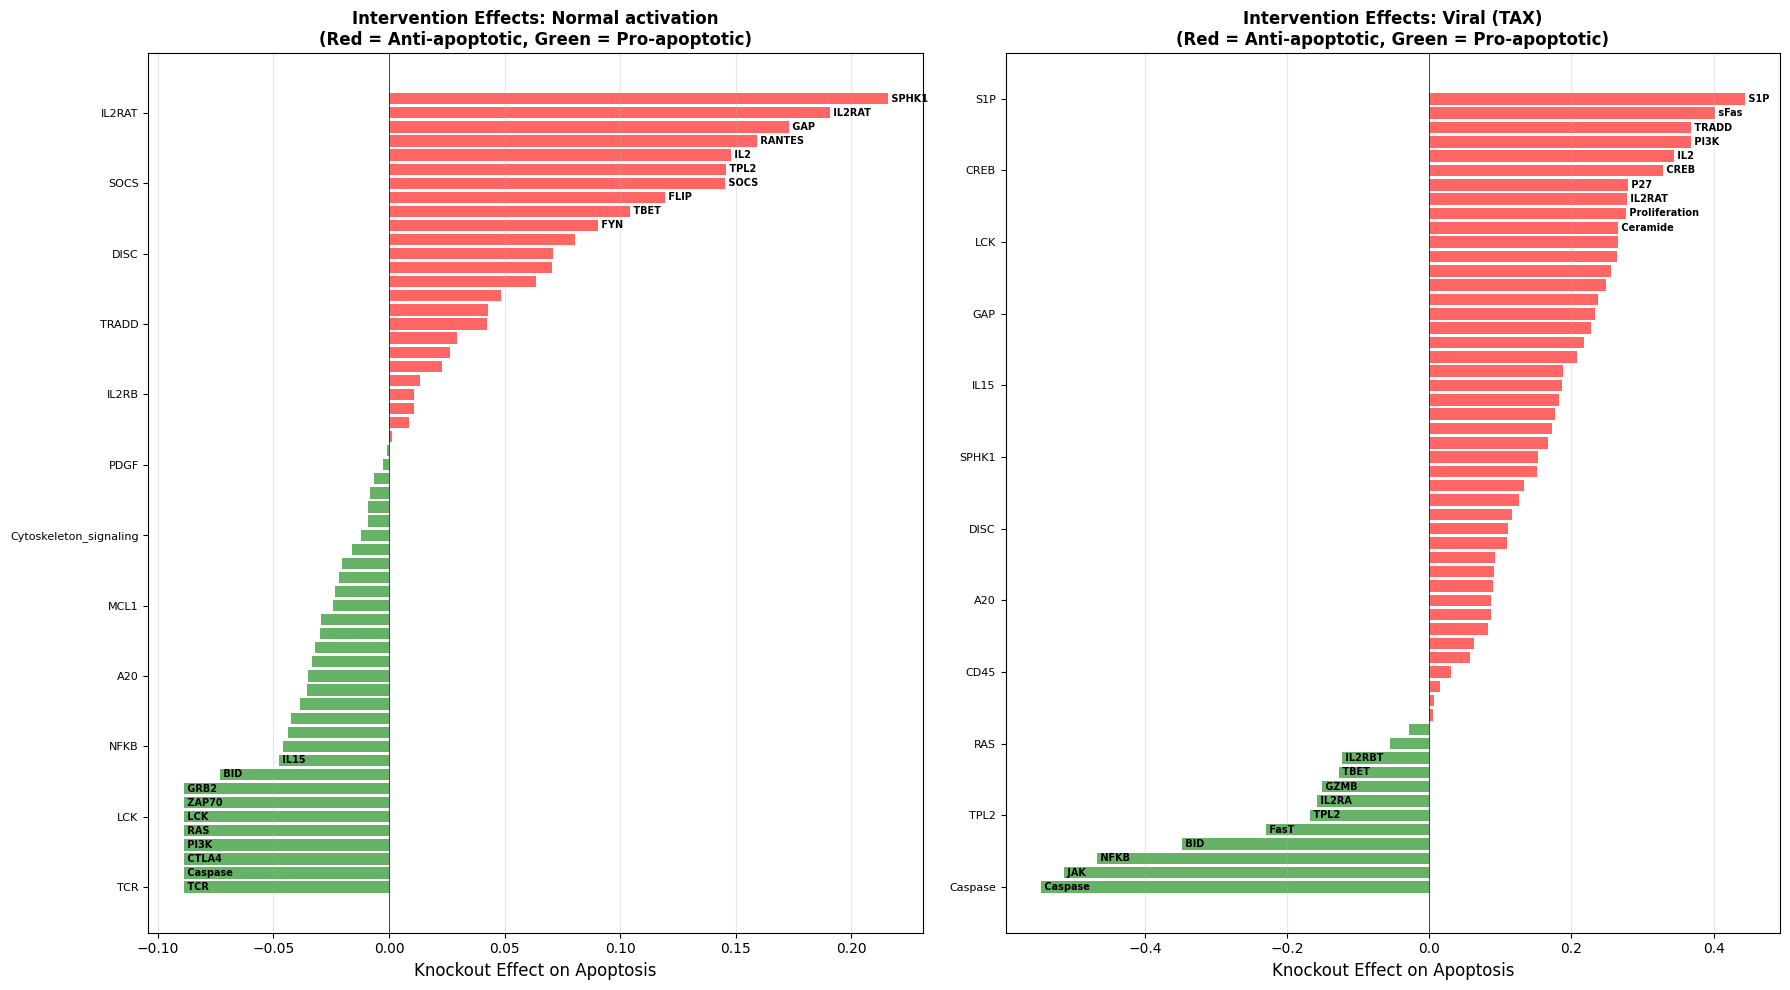

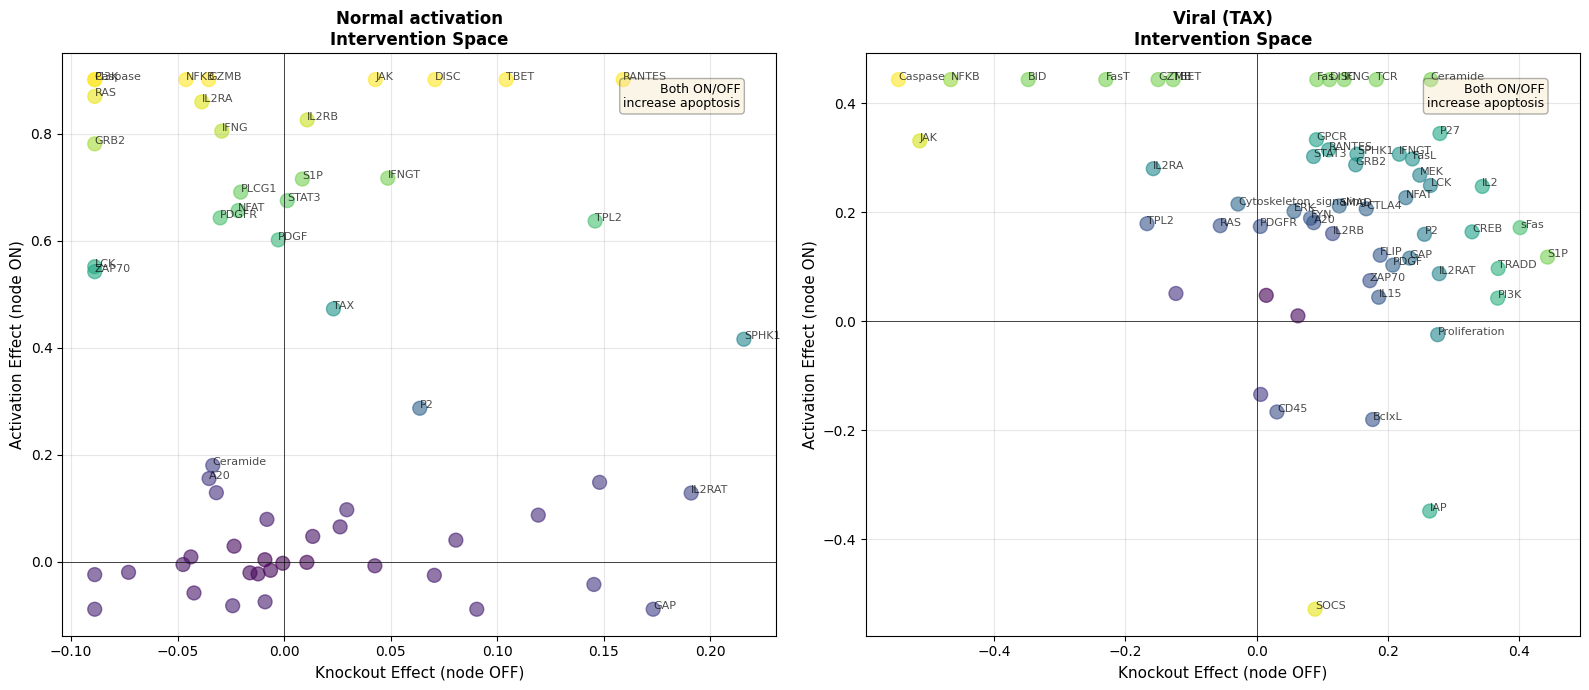

In [39]:
# Visualize intervention effects
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

for idx, (scenario_name, df) in enumerate(intervention_results.items()):
    ax = axes[idx]
    
    # Sort by knockout effect
    df_sorted = df.sort_values('knockout_effect')
    
    # Create bar plot
    y_pos = np.arange(len(df_sorted))
    
    # Color code: red = increases apoptosis, green = decreases apoptosis
    colors = ['red' if x > 0 else 'green' for x in df_sorted['knockout_effect']]
    
    ax.barh(y_pos, df_sorted['knockout_effect'], color=colors, alpha=0.6)
    ax.set_yticks(y_pos[::5])  # Show every 5th label to avoid crowding
    ax.set_yticklabels(df_sorted['node'].iloc[::5], fontsize=8)
    ax.set_xlabel('Knockout Effect on Apoptosis', fontsize=12)
    ax.set_title(f'Intervention Effects: {scenario_name}\n(Red = Anti-apoptotic, Green = Pro-apoptotic)', 
                 fontsize=12, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(axis='x', alpha=0.3)
    
    # Highlight top targets
    top_10_anti = df.nlargest(10, 'knockout_effect')['node'].tolist()
    top_10_pro = df.nsmallest(10, 'knockout_effect')['node'].tolist()
    
    for i, node in enumerate(df_sorted['node']):
        if node in top_10_anti or node in top_10_pro:
            ax.text(df_sorted['knockout_effect'].iloc[i], y_pos[i], 
                   f' {node}', va='center', fontsize=7, fontweight='bold')

plt.tight_layout()
plt.show()

# Create scatter plot comparing knockout vs activation effects
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for idx, (scenario_name, df) in enumerate(intervention_results.items()):
    ax = axes[idx]
    
    ax.scatter(df['knockout_effect'], df['activate_effect'], 
              s=100, alpha=0.6, c=df['max_effect'], cmap='viridis')
    
    # Add quadrant lines
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    # Label interesting points
    for _, row in df.iterrows():
        if abs(row['knockout_effect']) > 0.15 or abs(row['activate_effect']) > 0.15:
            ax.annotate(row['node'], 
                       (row['knockout_effect'], row['activate_effect']),
                       fontsize=8, alpha=0.7)
    
    ax.set_xlabel('Knockout Effect (node OFF)', fontsize=11)
    ax.set_ylabel('Activation Effect (node ON)', fontsize=11)
    ax.set_title(f'{scenario_name}\nIntervention Space', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add quadrant labels
    ax.text(0.95, 0.95, 'Both ON/OFF\nincrease apoptosis', 
           transform=ax.transAxes, ha='right', va='top', fontsize=9, 
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()


In [40]:
# Network structure analysis - identify critical nodes by graph topology
print("\n" + "="*80)
print("NETWORK TOPOLOGY ANALYSIS - STRUCTURAL CHOKEPOINTS")
print("="*80)

# Calculate various centrality measures
betweenness = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())

# PageRank (importance based on incoming connections)
pagerank = nx.pagerank(G)

# Create dataframe with all metrics
structural_metrics = pd.DataFrame({
    'node': list(G.nodes()),
    'betweenness': [betweenness[n] for n in G.nodes()],
    'closeness': [closeness[n] for n in G.nodes()],
    'in_degree': [in_degree[n] for n in G.nodes()],
    'out_degree': [out_degree[n] for n in G.nodes()],
    'pagerank': [pagerank[n] for n in G.nodes()],
    'total_degree': [in_degree[n] + out_degree[n] for n in G.nodes()]
})

# Find paths to apoptosis
print("\nAnalyzing paths to Apoptosis...")
paths_to_apoptosis = []
for input_node in input_nodes:
    try:
        # Get all simple paths up to length 10
        paths = list(nx.all_simple_paths(G, input_node, "Apoptosis", cutoff=10))
        paths_to_apoptosis.extend(paths)
        print(f"  From {input_node}: {len(paths)} paths found")
    except nx.NetworkXNoPath:
        print(f"  From {input_node}: no paths")

# Count node frequency in paths to apoptosis
from collections import Counter
node_path_frequency = Counter()
for path in paths_to_apoptosis:
    for node in path[1:-1]:  # Exclude input and apoptosis itself
        node_path_frequency[node] += 1

structural_metrics['path_frequency'] = structural_metrics['node'].map(
    lambda x: node_path_frequency.get(x, 0)
)

# Normalize path frequency
max_freq = structural_metrics['path_frequency'].max()
if max_freq > 0:
    structural_metrics['path_frequency_norm'] = structural_metrics['path_frequency'] / max_freq
else:
    structural_metrics['path_frequency_norm'] = 0

print(f"\nTotal unique paths to Apoptosis: {len(paths_to_apoptosis)}")
print(f"\nNodes most frequently in paths to Apoptosis (chokepoints):")
print("-"*80)
top_chokepoints = structural_metrics.nlargest(20, 'path_frequency')[
    ['node', 'path_frequency', 'betweenness', 'in_degree', 'out_degree']
]
print(top_chokepoints.to_string(index=False))

print(f"\n\nMost central nodes by betweenness centrality:")
print("-"*80)
top_between = structural_metrics.nlargest(20, 'betweenness')[
    ['node', 'betweenness', 'path_frequency', 'total_degree']
]
print(top_between.to_string(index=False))

print(f"\n\nHighest connectivity (total degree):")
print("-"*80)
top_degree = structural_metrics.nlargest(20, 'total_degree')[
    ['node', 'total_degree', 'in_degree', 'out_degree', 'betweenness']
]
print(top_degree.to_string(index=False))



NETWORK TOPOLOGY ANALYSIS - STRUCTURAL CHOKEPOINTS

Analyzing paths to Apoptosis...
  From TAX: 90 paths found
  From CD45: 170 paths found
  From Stimuli: 213 paths found
  From PDGF: 221 paths found
  From IL15: 401 paths found

Total unique paths to Apoptosis: 1095

Nodes most frequently in paths to Apoptosis (chokepoints):
--------------------------------------------------------------------------------
   node  path_frequency  betweenness  in_degree  out_degree
Caspase            1095     0.331316          6           2
    BID             608     0.070225          5           3
   NFKB             602     0.194958          6          11
   IFNG             577     0.108995          7           5
    JAK             440     0.130443          7           3
   DISC             415     0.098704          6           3
    IAP             397     0.043347          3           3
   GZMB             354     0.110190          4           3
   PI3K             348     0.159527          3  

In [41]:
# Combine intervention results with structural analysis
print("\n" + "="*80)
print("INTEGRATED ANALYSIS - COMBINING INTERVENTIONS WITH NETWORK STRUCTURE")
print("="*80)

# Merge intervention results with structural metrics for the "Normal activation" scenario
scenario_name = "Normal activation"
integrated_df = intervention_results[scenario_name].merge(
    structural_metrics, on='node', how='left'
)

# Calculate a composite "drug target score" 
# Ideal target: high knockout effect (anti-apoptotic) + high centrality + in paths
integrated_df['anti_apoptotic_score'] = (
    integrated_df['knockout_effect'] * 0.4 +  # How much it prevents apoptosis
    integrated_df['betweenness'] * 0.3 +      # Structural importance
    integrated_df['path_frequency_norm'] * 0.3  # On paths to apoptosis
)

# Pro-apoptotic score (opposite)
integrated_df['pro_apoptotic_score'] = (
    -integrated_df['knockout_effect'] * 0.4 +  # Knockout reduces apoptosis
    integrated_df['betweenness'] * 0.3 + 
    integrated_df['path_frequency_norm'] * 0.3
)

print("\nTOP ANTI-APOPTOTIC DRUG TARGETS (prevent apoptosis):")
print("-"*80)
print("High knockout effect + high centrality + on paths to apoptosis")
print()
top_anti_targets = integrated_df.nlargest(15, 'anti_apoptotic_score')[
    ['node', 'knockout_effect', 'betweenness', 'path_frequency', 'anti_apoptotic_score']
]
print(top_anti_targets.to_string(index=False))

print("\n\nTOP PRO-APOPTOTIC DRUG TARGETS (promote apoptosis):")
print("-"*80)
print("Knockout reduces apoptosis + high centrality + on paths to apoptosis")
print()
top_pro_targets = integrated_df.nlargest(15, 'pro_apoptotic_score')[
    ['node', 'knockout_effect', 'betweenness', 'path_frequency', 'pro_apoptotic_score']
]
print(top_pro_targets.to_string(index=False))

# Find nodes with high intervention effect but low centrality (surprising targets)
integrated_df['surprise_score'] = (
    integrated_df['max_effect'].abs() / (integrated_df['betweenness'] + 0.01)
)

print("\n\nSURPRISE TARGETS (high intervention effect, low structural centrality):")
print("-"*80)
print("These nodes have disproportionate functional importance vs their network position")
print()
surprise_targets = integrated_df.nlargest(15, 'surprise_score')[
    ['node', 'max_effect', 'betweenness', 'path_frequency', 'surprise_score']
]
print(surprise_targets.to_string(index=False))



INTEGRATED ANALYSIS - COMBINING INTERVENTIONS WITH NETWORK STRUCTURE

TOP ANTI-APOPTOTIC DRUG TARGETS (prevent apoptosis):
--------------------------------------------------------------------------------
High knockout effect + high centrality + on paths to apoptosis

   node  knockout_effect  betweenness  path_frequency  anti_apoptotic_score
Caspase        -0.088877     0.331316            1095              0.363844
   NFKB        -0.046040     0.194958             602              0.205003
   IFNG        -0.029277     0.108995             577              0.179070
    IL2         0.148016     0.091804             331              0.177433
    JAK         0.042785     0.130443             440              0.176795
   DISC         0.070757     0.098704             415              0.171613
    BID        -0.073011     0.070225             608              0.158439
   FLIP         0.119232     0.049605             334              0.154081
   TBET         0.104168     0.064268          

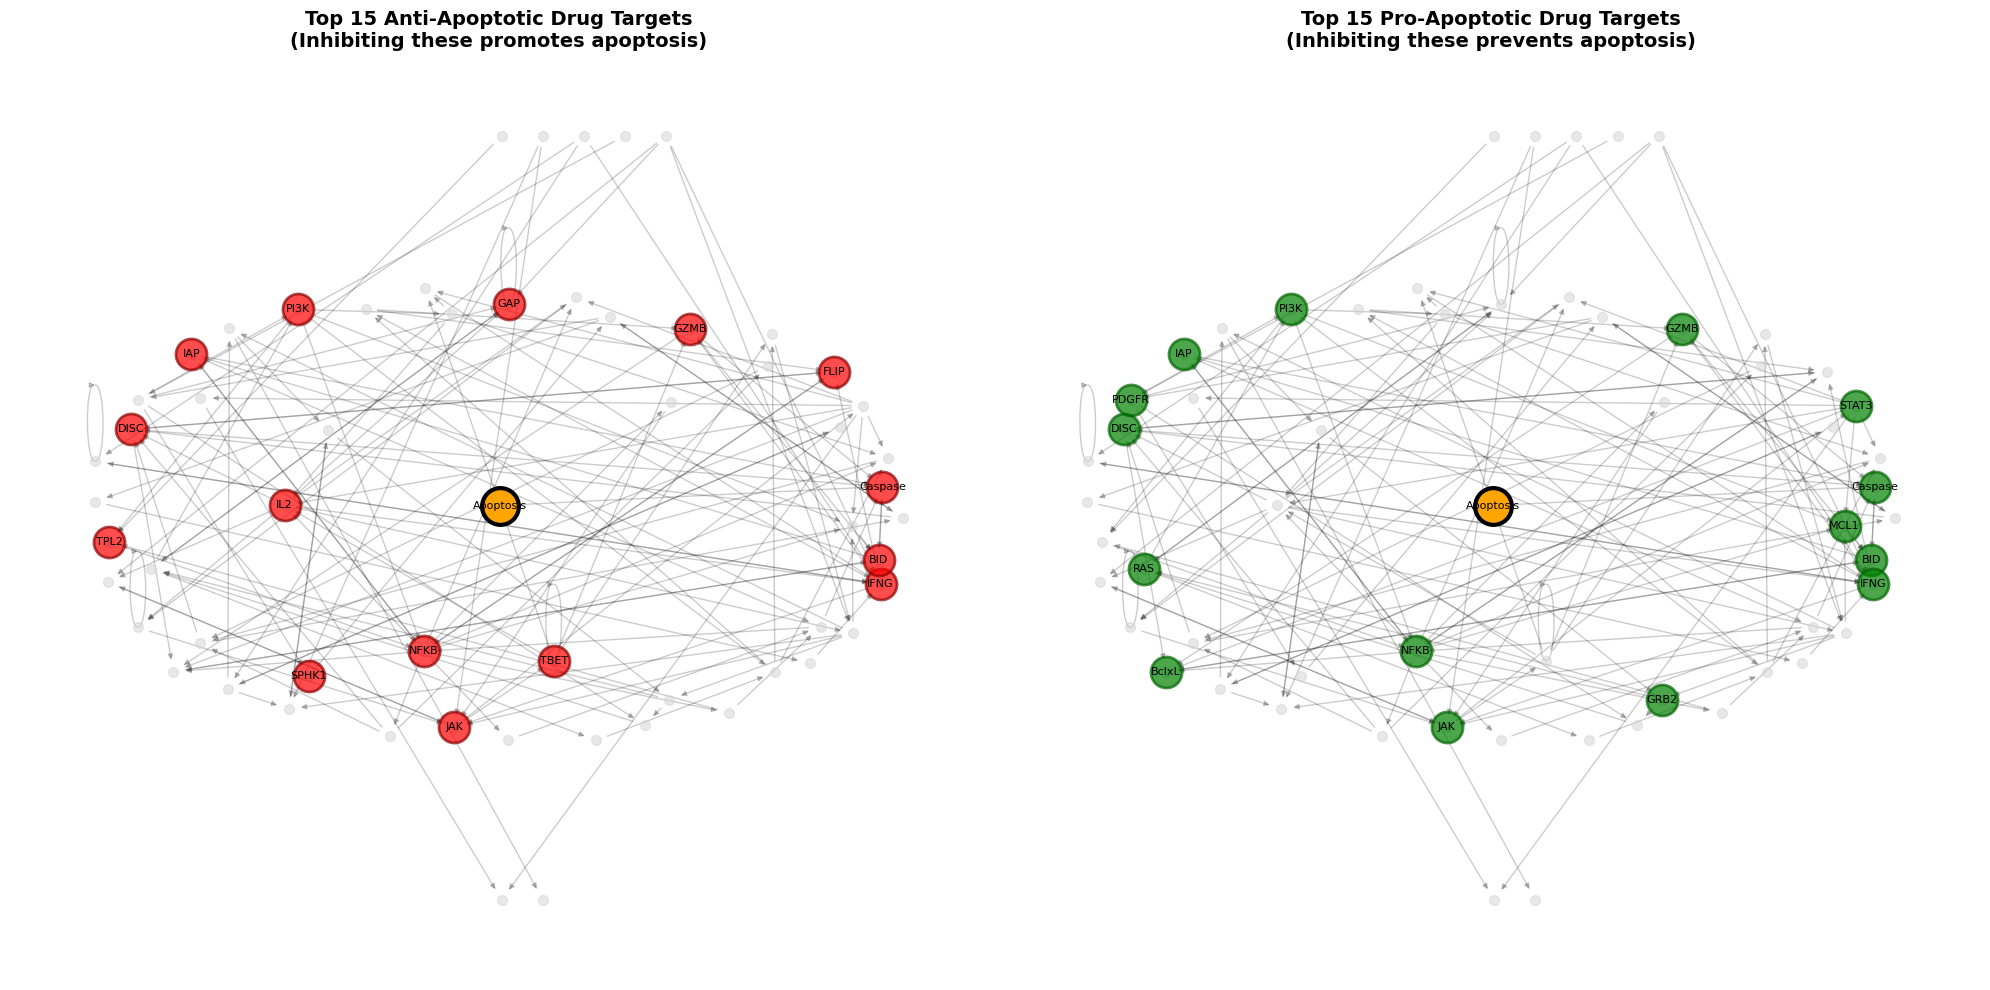

In [42]:
# Visualize top drug targets on network
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Get top targets
top_15_anti = integrated_df.nlargest(15, 'anti_apoptotic_score')['node'].tolist()
top_15_pro = integrated_df.nlargest(15, 'pro_apoptotic_score')['node'].tolist()

# Create position layout (reuse from earlier)
pos = {}
for i, node in enumerate(input_nodes):
    pos[node] = (i * 2, 10)
for i, node in enumerate(output_nodes):
    pos[node] = (i * 2, 0)
middle_pos = nx.spring_layout(G.subgraph(middle_nodes), k=2, iterations=50, seed=42)
for node, (x, y) in middle_pos.items():
    pos[node] = (x * 20, 5 + y * 3)

# Plot 1: Anti-apoptotic targets
ax = axes[0]
edges_to_draw = [(u, v) for u, v in G.edges() if u != 'Apoptosis']
nx.draw_networkx_edges(G, pos, edgelist=edges_to_draw, alpha=0.2, 
                       arrows=True, arrowsize=8, ax=ax)

# Draw all nodes small and gray
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='lightgray', 
                       alpha=0.5, ax=ax)

# Highlight top anti-apoptotic targets in red
nx.draw_networkx_nodes(G, pos, nodelist=top_15_anti, 
                       node_size=500, node_color='red', 
                       alpha=0.7, edgecolors='darkred', linewidths=2, ax=ax)

# Highlight apoptosis node
nx.draw_networkx_nodes(G, pos, nodelist=['Apoptosis'], 
                       node_size=700, node_color='orange', 
                       edgecolors='black', linewidths=3, ax=ax)

# Label top targets
labels = {node: node for node in top_15_anti + ['Apoptosis']}
nx.draw_networkx_labels(G, pos, labels, font_size=8, ax=ax)

ax.set_title('Top 15 Anti-Apoptotic Drug Targets\n(Inhibiting these promotes apoptosis)', 
             fontsize=14, fontweight='bold')
ax.axis('off')

# Plot 2: Pro-apoptotic targets  
ax = axes[1]
nx.draw_networkx_edges(G, pos, edgelist=edges_to_draw, alpha=0.2, 
                       arrows=True, arrowsize=8, ax=ax)

nx.draw_networkx_nodes(G, pos, node_size=50, node_color='lightgray', 
                       alpha=0.5, ax=ax)

# Highlight top pro-apoptotic targets in green
nx.draw_networkx_nodes(G, pos, nodelist=top_15_pro, 
                       node_size=500, node_color='green', 
                       alpha=0.7, edgecolors='darkgreen', linewidths=2, ax=ax)

nx.draw_networkx_nodes(G, pos, nodelist=['Apoptosis'], 
                       node_size=700, node_color='orange', 
                       edgecolors='black', linewidths=3, ax=ax)

labels = {node: node for node in top_15_pro + ['Apoptosis']}
nx.draw_networkx_labels(G, pos, labels, font_size=8, ax=ax)

ax.set_title('Top 15 Pro-Apoptotic Drug Targets\n(Inhibiting these prevents apoptosis)', 
             fontsize=14, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()


## Summary: Key Findings

### Robustness Analysis Results

This analysis identified therapeutic targets by combining:
1. Measuring how knockout/activation affects apoptosis
2. Finding structural chokepoints and key paths
3. Ensuring targets work across conditions

### Target Categories:

**Anti-apoptotic targets**
- Nodes where knockout increases apoptosis
- BclxL, MCL1, IAP, FLIP

**Pro-apoptotic targets**
- Nodes where knockout decreases apoptosis  
- Caspase, BID, Fas pathway

**Structural chokepoints**:
- Nodes with high betweenness centrality
- Frequently appear in paths to apoptosis
- Control information flow through network

**Surprise targets**:
- High functional impact despite low structural centrality
- May represent regulatory nodes or switches
- Could be less obvious but highly effective targets
